In [319]:
import pandas as pd
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
from torch_geometric.utils import from_networkx

In [320]:
import sys, os
sys.path.append('../../gnumap/')
from models.train_models import *
from scipy import optimize

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from codecarbon import OfflineEmissionsTracker
from umap_functions import *
from simulation_utils import make_roll

In [ ]:
N_NEIGHBOURS = 5

In [ ]:
make_roll(c=0.6, v=4, omega=12, n_samples = 2000, n_neighbours = 30,
              a = 2, b = 2, scale=0.5, plot=True, features=None,
              standardize=True)
"""
X: coordinates for swissroll
t: underlying beta samples
new_data: node features
"""

In [ ]:
import random
random.seed(12345)
X, t, new_data = make_roll(n_neighbours = N_NEIGHBOURS, scale=0.1, n_samples = 4000, features='coordinates')
# new_data is graph object

In [ ]:
x = X[:,0]
y = X[:,1]
z = X[:,2]

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=t, cmap='Spectral')

In [ ]:
# import umap.umap_ as umap
import umap
import numpy as np
from sklearn.neighbors import kneighbors_graph

X = np.vstack([np.array(x),np.array(y),np.array(z)]).T
A_dist = kneighbors_graph(X, N_NEIGHBOURS, mode='distance', include_self=False)
embedding = umap.UMAP(n_components=2, n_neighbors= 10, min_dist= 0.3).fit_transform(X)
plt.scatter(*embedding.T, s=10, c=t, alpha=0.5, cmap='Spectral')

In [ ]:
# more local when n_neighbors is small
embedding_20 = umap.UMAP(n_components=2, n_neighbors= 20, min_dist= 0.1).fit_transform(X)
plt.scatter(*embedding_20.T, s=10, c=t, alpha=0.5, cmap='Spectral')

In [ ]:
# more global when n_neighbors is large
embedding_200 = umap.UMAP(n_components=2, n_neighbors= 200, min_dist= 0.1).fit_transform(X)
plt.scatter(*embedding_200.T, s=10, c=t, alpha=0.5, cmap='Spectral')

In [ ]:
A_dist[:,0]

In [ ]:
new_data.x # coordinate to node features

In [ ]:
X

In [ ]:
# A_dist = kneighbors_graph(X, 5, mode='distance', include_self=False)
### Very sensitive to wrong edges
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A_dist), 
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=t, cmap='Spectral', with_labels=False)
plt.show()

In [ ]:
A_dist = kneighbors_graph(X, 3, mode='distance', include_self=False)
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A_dist),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=t, cmap='Spectral', with_labels=False)
plt.show()

In [ ]:
A_dist = kneighbors_graph(X, 10, mode='distance', include_self=False)
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A_dist),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=t, cmap='Spectral', with_labels=False)
plt.show()

In [ ]:
A_dist = kneighbors_graph(X, 20, mode='distance', include_self=False)
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A_dist),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=t, cmap='Spectral', with_labels=False)
plt.show()

In [ ]:
A_dist = kneighbors_graph(X, 200, mode='distance', include_self=False)
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A_dist),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=t, cmap='Spectral', with_labels=False)
plt.show()

# Canonical Correlation Analysis to Self-supervised Graph Neural Networks
 https://github.com/hengruizhang98/CCA-SSG

In [ ]:
model = train_cca_ssg(new_data, channels=2, hid_dim=256, lambd=1e2,
                  n_layers=2, epochs=1000, lr=1e-2,
                  fmr=0.2, edr =0.4, name_file="test",
                  device=None)
plt.hist(model.get_embedding(new_data).numpy())
plt.show()
plt.figure()
out = model.get_embedding(new_data).numpy()
u = out
plt.scatter(u[:,0], u[:,1], c = t, 
            cmap="Spectral")
plt.show()

# Deep Graph Infomax
https://github.com/PetarV-/DGI

In [ ]:
# First, create "results" folder at current working directory
model = train_dgi(new_data,512, 2, 2, patience=20,
              epochs=200, lr=1e-3, name_file="1")
plt.hist(model.get_embedding(new_data).numpy())
plt.figure()
out = model.get_embedding(new_data).numpy()
u = out
plt.scatter(u[:,0], u[:,1], c = t, 
            cmap="Spectral")
plt.show()

In [ ]:
from numbers import Number
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from models.aggregation import GAPPNP
class GNN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int,
                 output_dim: int, n_layers: int,
                 activation: str='relu', slope: float=.1,
                 device: str='cpu',
                 alpha_res: float=0, alpha: float=0.5,
                 beta: float=1., gnn_type: str = 'symmetric',
                 norm: str='normalize',
                 must_propagate=None,
                 lambd_corr: float = 0):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.gnn_type = gnn_type
        self.n_layers = n_layers
        self.device = device
        self.alpha_res = alpha_res
        self.alpha = alpha
        self.beta= beta
        self.must_propagate = must_propagate
        self.propagate = GAPPNP(K=1, alpha_res=self.alpha_res,
                                alpha = self.alpha,
                                gnn_type=self.gnn_type,
                                beta = self.beta)
        self.norm = norm
        if self.must_propagate is None:
            self.must_propagate = [True] * self.n_layers
        if isinstance(hidden_dim, Number):
            self.hidden_dim = [hidden_dim] * (self.n_layers - 1)
        elif isinstance(hidden_dim, list):
            self.hidden_dim = hidden_dim
        else:
            raise ValueError('Wrong argument type for hidden_dim: {}'.format(hidden_dim))

        if isinstance(activation, str):
            self.activation = [activation] * (self.n_layers - 1)
        elif isinstance(activation, list):
            self.hidden_dim = activation
        else:
            raise ValueError('Wrong argument type for activation: {}'.format(activation))

        self._act_f = []
        for act in self.activation:
            if act == 'lrelu':
                self._act_f.append(lambda x: F.leaky_relu(x, negative_slope=slope))
            elif act == 'relu':
                self._act_f.append(lambda x: torch.nn.ReLU()(x))
            elif act == 'xtanh':
                self._act_f.append(lambda x: self.xtanh(x, alpha=slope))
            elif act == 'sigmoid':
                self._act_f.append(F.sigmoid)
            elif act == 'none':
                self._act_f.append(lambda x: x)
            else:
                ValueError('Incorrect activation: {}'.format(act))

        if self.n_layers == 1:
            _fc_list = [nn.Linear(self.input_dim, self.output_dim)]
        else:
            _fc_list = [nn.Linear(self.input_dim, self.hidden_dim[0])]
            for i in range(1, self.n_layers - 1):
                _fc_list.append(nn.Linear(self.hidden_dim[i - 1], self.hidden_dim[i]))
            _fc_list.append(nn.Linear(self.hidden_dim[self.n_layers - 2], self.output_dim))
        self.fc = nn.ModuleList(_fc_list)
        self.to(self.device)

    @staticmethod
    def xtanh(x, alpha=.1):
        """tanh function plus an additional linear term"""
        return x.tanh() + alpha * x

    def forward(self, x, edge_index):
        h = x
        for c in range(self.n_layers):
            if c == self.n_layers - 1:
                h = self.fc[c](h)
                if self.norm == 'normalize' and c==0:
                    h = F.normalize(h, p=2, dim=1)
                elif self.norm == 'standardize'and c==0:
                    h = (h - h.mean(0)) / h.std(0)
                elif self.norm == 'uniform'and c==0:
                    h = 1 * (h - h.min()) / (h.max() - h.min())
                elif self.norm == 'col_uniform'and c==0:
                    h = 1 * (h - h.min(0)[0].reshape([1,-1]))/ (h.max(0)[0].reshape([1,-1])-h.min(0)[0].reshape([1,-1]))

            else:
                h = self.fc[c](h)
                h = F.dropout(h, p=0.5, training=self.training)
                if self.must_propagate[c]:
                    h = self.propagate(h, edge_index)
                if self.norm == 'normalize':
                    h = F.normalize(h, p=2, dim=1)
                elif self.norm == 'standardize':
                    h = (h - h.mean(0)) / h.std(0) #z1 = (h1 - h1.mean(0)) / h1.std(0)
                elif self.norm == 'uniform':
                    h = 1 * (h - h.min()) / (h.max() - h.min())
                elif self.norm == 'col_uniform':
                    h = 1 * (h - h.min(0)[0].reshape([1,-1]))/ (h.max(0)[0].reshape([1,-1])-h.min(0)[0].reshape([1,-1]))
                h = self._act_f[c](h)
        if self.norm == 'standardize_last':
            h = (h - h.mean(0)) / h.std(0)
        return h


# GNUMAP

densmap reference: https://www.biorxiv.org/content/10.1101/2020.05.12.077776v1.full.pdf
$ L^{denseMAP} = CE(P||Q) - \lambda Corr(r_o^{UMAP}, r_e^{UMAP}) $

In [ ]:
if torch_geometric.utils.is_undirected(new_data.edge_index):
    new_edge_index, new_edge_attr = new_data.edge_index, new_data.edge_weight
else:
    new_edge_index, new_edge_attr = torch_geometric.utils.to_undirected(new_data.edge_index, new_data.edge_weight)

#### transform edge index into knn matrix
knn = []
for i in range(new_data.num_nodes):
    knn += [list(np.sort(list(new_edge_attr[(new_edge_index[0]==i) & (new_edge_index[1]!=i )].numpy())))]
knn_dists = pd.DataFrame(knn).fillna(0).values
sigmas, rhos = smooth_knn_dist(
        knn_dists,
        float(15),
        local_connectivity=float(1),
         )
vals = [ np.exp(-(np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0])) /
                (sigmas[new_edge_index[0,i]])) for i in range(len(new_edge_attr))]

high = []
for i in range(new_data.num_nodes):
    high.append(
        np.insert((new_edge_attr[(new_edge_index[0]==i) & (new_edge_index[1]!=i )].numpy())/new_edge_attr[(new_edge_index[0] == i) & (new_edge_index[1] != i)].sum().numpy(),0,0)
    )
highs  = np.hstack(high)

#print(np.where(vals > 1e5))
rows = new_edge_index[0,:].numpy()
cols = new_edge_index[1,:].numpy()
vals = np.array(vals)
vals[vals<1e-5] = 0
result = scipy.sparse.coo_matrix(
    (highs, (rows, cols)), shape=(X.shape[0], X.shape[0])
)
result.eliminate_zeros()
target_graph_index, target_graph_weights = from_scipy_sparse_matrix(result)


In [ ]:
vals.sum()

In [ ]:
import numpy as np
from carbontracker.tracker import CarbonTracker
import cProfile
import os
import scipy
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops, negative_sampling
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils import to_scipy_sparse_matrix, to_networkx, from_scipy_sparse_matrix
import time
from umap_functions import *

def train_gnumap(data, hid_dim, dim, n_layers=2, target=None,
                 method = 'laplacian', must_propagate=None,
                 norm='normalize', neighbours=15,
                 patience=20, epochs=200, lr=1e-3, wd=1e-2,
                 min_dist=0.1, name_file="1", subsampling=None,
                 alpha: float=0.5, spread = 1.0, lambd_corr=1e-2,
                 beta: float=1., gnn_type: str = 'symmetric',
                 repulsion_strength=None,
                 local_connectivity=1,
                 device=None, colours=None):


    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    EPS_0 = data.num_edges/ (data.num_nodes ** 2)
    _a, _b = find_ab_params(spread, min_dist) # spread , min_dist given as hyperparameter

    #if torch_geometric.utils.is_undirected(data.edge_index):
    #    new_edge_index, new_edge_attr = torch_geometric.utils.to_undirected(data.edge_index, data.edge_weight)
    #else:
    #    new_edge_index, new_edge_attr = data.edge_index, data.edge_weight

    if torch_geometric.utils.is_undirected(data.edge_index):
        new_edge_index, new_edge_attr = data.edge_index, data.edge_weight
    else:
        new_edge_index, new_edge_attr = torch_geometric.utils.to_undirected(data.edge_index, data.edge_weight)

    #### transform edge index into knn matrix
    knn = []
    for i in range(data.num_nodes):
        knn += [list(np.sort(list(new_edge_attr[(new_edge_index[0]==i) & (new_edge_index[1]!=i )].numpy())))]
    knn_dists = pd.DataFrame(knn).fillna(0).values
    sigmas, rhos = smooth_knn_dist(
            knn_dists,
            float(neighbours),
            local_connectivity=float(local_connectivity),
             )

    # Maybe use the distance as the original distribution?
    vals = [ np.exp(-(np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0])) /
                    (sigmas[new_edge_index[0,i]])) for i in range(len(new_edge_attr))]

    #print(np.where(vals > 1e5))
    rows = new_edge_index[0,:].numpy()
    cols = new_edge_index[1,:].numpy()
    vals = np.array(vals)
    vals[vals<1e-5] = 0

    high = []
    for i in range(data.num_nodes):
        high.append(
            np.insert((new_edge_attr[(new_edge_index[0]==i) & (new_edge_index[1]!=i )].numpy())/new_edge_attr[(new_edge_index[0] == i) & (new_edge_index[1] != i)].sum().numpy(),0,0)
        )
    # highs = np.hstack(high)
    highs  = new_edge_attr/data.num_edges
    p =[]
    for i in range(data.num_nodes):
        p.append(
            highs[(new_edge_index[0] == i) & (new_edge_index[1] != i)].sum().numpy()
        )
    eta = data.edge_weight
    for i in range(len(data.edge_weight)):
        eta[i] = (p[data.edge_index[0,i]]+p[data.edge_index[1,i]])/2*data.x.shape[0]

    result = scipy.sparse.coo_matrix(
  #      (vals, (rows, cols)), shape=(X.shape[0], X.shape[0])
         (highs, (rows, cols)), shape=(X.shape[0], X.shape[0])
    )
    result.eliminate_zeros()
    target_graph_index, target_graph_weights = from_scipy_sparse_matrix(result)



    #### Prune
    EPS = 1e-29 #math.exp(-1.0/(2*_b) * math.log(1.0/_a * (1.0/EPS_0 -1)))
    print("Epsilon is " + str(EPS))
    print("Hyperparameters a = " + str(_a) + " and b = " + str(_b))



    model = GNN(data.num_features, hid_dim, dim, n_layers=n_layers,
                must_propagate=must_propagate,
                norm=norm)
    model = model.to(device)
    model.apply(init_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                             weight_decay=wd)
    new_data = Data(x=data.x, edge_index=target_graph_index,
                    y=data.y, edge_weight=target_graph_weights)
    sparsity =  new_data.num_edges/(new_data.num_nodes**2 -new_data.num_nodes)
    if repulsion_strength is None:
        repulsion_strength = 1.0/sparsity
        # we have way more samples that are "not" connected(sparsity), so need to give more weight to negative sampling to get balanced results
    row_pos, col_pos =  new_data.edge_index
    index = (row_pos != col_pos)
        # to exclude self-connectivity
    edge_weights_pos = new_data.edge_weight#[index]

    if target is not None:
        edge_weights_pos = fast_intersection(row_pos[index], col_pos[index], edge_weights_pos,
                                             target, unknown_dist=1.0, far_dist=5.0)
        # p_{ij}
    if subsampling is None:
        row_neg, col_neg = negative_sampling(new_data.edge_index, num_neg_samples = 5 * new_data.edge_index.shape[1] )
        # m = 5
        index_neg = (row_neg != col_neg)
        # edge_weights_neg = EPS * torch.ones(len(row_neg))
        edge_weights_neg = m*torch.ones(len(row_neg))
        if target is not None:
            edge_weights_neg = fast_intersection(row_neg[index_neg], col_neg[index_neg], edge_weights_neg,
                                                 target, unknown_dist=1.0, far_dist=5.0)
    best_t=0
    cnt_wait = 0
    best=1e9
    log_sigmoid = torch.nn.LogSigmoid()
    edges = [(e[0],e[1]) for _, e in enumerate(data.edge_index.numpy().T)]
    for epoch in range(epochs):
        tic_epoch = time.time()
        model.train()
        optimizer.zero_grad()
        tic = time.time()
        out = model(data.x.float(), data.edge_index)
        diff_norm = torch.sum(torch.square(out[row_pos[index]] - out[col_pos[index]]), 1)
        diff_norm = torch.clip(diff_norm, min=1e-3)
        log_q = - torch.log1p(_a *  diff_norm ** _b) # 1/(1+a*d^2b)
        # log_q = - torch.log1p(1+ diff_norm)
        loss_pos = - torch.mean(edge_weights_pos[index] * log_sigmoid(log_q)) - torch.mean((1. - edge_weights_pos[index]) *  (log_sigmoid(log_q) - log_q ) * repulsion_strength)
        # log(q/(q+1))


        if subsampling is None:
            diff_norm_neg = torch.sum(torch.square(out[row_neg[index_neg]] - out[col_neg[index_neg]]), 1) #+ 1e-3
            diff_norm_neg = torch.clip(diff_norm_neg, min=1e-3)
            log_q_neg = - torch.log1p(_a *  diff_norm_neg ** _b)
            # log_q_neg = - torch.log1p(1+ diff_norm_neg)
        else:
            row_neg, col_neg = negative_sampling(new_data.edge_index,
                                                 num_neg_samples=subsampling)
            index_neg = (row_neg != col_neg)
            edge_weights_neg = EPS * torch.ones(len(row_neg))
            if target is not None:
                edge_weights_neg = fast_intersection(row_neg[index_neg],
                                                     col_neg[index_neg], edge_weights_neg,
                                                     target, unknown_dist=1.0, far_dist=5.0)
            diff_norm_neg = torch.sum(torch.square(out[row_neg[index_neg]] - out[col_neg[index_neg]]), 1) #+ 1e-3
            diff_norm_neg = torch.clip(diff_norm_neg, min=1e-3)
            log_q_neg = - torch.log1p(_a *  diff_norm_neg ** _b)
            # log_q_neg = - torch.log1p(1+ diff_norm_neg)
        print("loss before neg", loss_pos)
        loss_neg = - torch.mean((log_sigmoid(log_q_neg) - log_q_neg ) * repulsion_strength)
        print("loss after neg", loss_neg)
        ### Add a term to make sure that the features are learned independently
        c1 = torch.mm(out.T, out)
        c1 = c1 / out.shape[0]
        iden = torch.tensor(np.eye(out.shape[1])).to(device)
        loss_dec1 = (torch.diag_embed(c1) - c1).pow(2).sum()
        loss = loss_pos + loss_neg +  lambd_corr * loss_dec1
        print("loss corr", lambd_corr * loss_dec1)
        print("loss final", loss)
        tic =  time.time()
        loss.backward()
        #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=4)
        optimizer.step()
        
        if epoch%10== 0:
            u = out.detach().numpy()
            plt.figure()
            plt.scatter(u[:,0], u[:,1], c = t, 
                        cmap="Spectral")
            plt.show()
            print(torch.mm(out.T, out)/ new_data.num_nodes)

        for g in optimizer.param_groups:
            g['lr'] = lr * (1.0 - (float(epoch) / float(epochs)))

        print('Epoch={:03d}, loss={:.4f}, time={:.4f}'.format(epoch, loss.item(),time.time()-tic_epoch))
        if loss < best:
            best = loss
            best_t = epoch
            cnt_wait = 0
            torch.save(model.state_dict(), os.getcwd()  + '/results/best_gnumap_'
                                          + str(method) + '_neigh' + str(neighbours)
                                          + '_dim' + str(dim) + '_' + name_file +  '.pkl')
        else:
            cnt_wait += 1
        if cnt_wait == patience and epoch>50:
            print('Early stopping at epoch {}!'.format(epoch))
            break
        #print("Time epoch after saving", time.time()-tic_epoch)
    #tracker.stop()
    print('Loading {}th epoch'.format(best_t))
    model.load_state_dict(torch.load(os.getcwd()  + '/results/best_gnumap_' +
                                     str(method) + '_neigh' + str(neighbours)
                                     + '_dim' + str(dim) + '_' + name_file + '.pkl'))
    return(model,target_graph_index, vals, knn_dists)

In [ ]:
model2, target_graph_index, vals, knn_dists=  train_gnumap(new_data, 
                                     target=None, hid_dim=1054, dim=2, 
                                     n_layers=3, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5, 
                                     gnn_type='symmetric', repulsion_strength=100,
                                     norm='uniform', neighbours=5,
                                      beta=1, patience=20, epochs=1000,
                                      lr=1e-1, 
                                    wd=1e-4,
                                    lambd_corr=1e-4,
                                       min_dist=0.01,
                       subsampling=100000)
out = model2(new_data.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t, 
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

In [ ]:
plt.hist(new_data.edge_weight)

In [ ]:
plt.hist(vals)

In [ ]:
len(vals)

In [ ]:
new_edge_index, new_edge_attr = remove_self_loops(new_data.edge_index, new_data.edge_weight)

In [ ]:
knn_dists
sigmas, rhos = smooth_knn_dist(
            knn_dists,
            float(2),
            local_connectivity=float(1.),
             )

In [ ]:
vals = []
for i in range(len(new_edge_attr))[:100]:
    vals+= [ np.exp(-(np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0])) /
                    (sigmas[new_edge_index[0,i]]))]
    print([i, np.exp(-(np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0])) /
                    (sigmas[new_edge_index[0,i]]))])

In [ ]:
i = 5
print(new_edge_index[:,i], new_edge_attr.numpy()[i] , rhos[new_edge_index[0,i]], sigmas[new_edge_index[0,i]])
print(np.max(new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0)/sigmas[new_edge_index[0,i]])

In [ ]:
np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0]
      )

In [ ]:
np.max(new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0)/sigmas[new_edge_index[0,i]]

In [ ]:
plt.hist(rhos)

In [ ]:
#xx = torch.ones((X.shape[0], 10))
new_data3 = copy.deepcopy(new_data)
# new_data2.x =  new_data.x[:,:2] # leave out z-axis
model2, target_index =  train_gnumap(new_data3,
                                     target=None, hid_dim=256, dim=2, 
                                     n_layers=1, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5, 
                                     gnn_type='symmetric', repulsion_strength=1.,
                                     norm='standardize', neighbours=2,
                                    beta=1, patience=20, epochs=1000,
                                       lr=1e-2, 
                                       wd=1e-4,
                                        lambd_corr=1.,
                                       min_dist=0.001,
                       subsampling=100000)
out = model2(new_data3.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t, 
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

In [ ]:
new_data4 = copy.deepcopy(new_data)
model2, target_graph_index, vals, knn_dists=  train_gnumap(new_data4,
                                     target=None, hid_dim=512, dim=2,
                                     n_layers=3, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=100,
                                     norm='uniform', neighbours=5,
                                      beta=1, patience=20, epochs=1000,
                                      lr=1e-1,
                                    wd=1e-4,
                                    lambd_corr=1e-4,
                                       min_dist=0.01,
                       subsampling=100000)
out = model2(new_data4.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

In [ ]:
#xx = torch.ones((X.shape[0], 10))
new_data5 = copy.deepcopy(new_data)
# new_data2.x =  new_data.x[:,:2] # leave out z-axis
model2, target_index =  train_gnumap(new_data5,
                                     target=None, hid_dim=512, dim=2,
                                     n_layers=1, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=1.,
                                     norm='standardize', neighbours=2,
                                    beta=1, patience=20, epochs=1000,
                                       lr=1e-2,
                                       wd=1e-4,
                                        lambd_corr=1.,
                                       min_dist=0.001,
                       subsampling=100000)
out = model2(new_data5.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

In [ ]:
new_data6 = copy.deepcopy(new_data)
model2, target_graph_index, vals, knn_dists=  train_gnumap(new_data6,
                                     target=None, hid_dim=256, dim=2,
                                     n_layers=3, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=100,
                                     norm='uniform', neighbours=5,
                                      beta=1, patience=20, epochs=1000,
                                      lr=1e-1,
                                    wd=1e-4,
                                    lambd_corr=1e-4,
                                       min_dist=0.01,
                       subsampling=100000)
out = model2(new_data6.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

In [ ]:
new_data7 = copy.deepcopy(new_data)
model2, target_graph_index, vals, knn_dists=  train_gnumap(new_data7,
                                     target=None, hid_dim=256, dim=2,
                                     n_layers=3, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=50,
                                     norm='uniform', neighbours=5,
                                      beta=1, patience=20, epochs=1000,
                                      lr=1e-1,
                                    wd=1e-4,
                                    lambd_corr=1e-4,
                                       min_dist=0.01,
                       subsampling=100000)
out = model2(new_data7.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

In [ ]:
new_data6 = copy.deepcopy(new_data)
model2, target_graph_index, vals, knn_dists=  train_gnumap(new_data6,
                                     target=None, hid_dim=256, dim=2,
                                     n_layers=2, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=100,
                                     norm='uniform', neighbours=5,
                                      beta=1, patience=20, epochs=1000,
                                      lr=1e-1,
                                    wd=1e-4,
                                    lambd_corr=1e-4,
                                       min_dist=0.01,
                       subsampling=100000)
out = model2(new_data6.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

In [ ]:
new_data7 = copy.deepcopy(new_data)
model2, target_graph_index, vals, knn_dists=  train_gnumap(new_data7,
                                     target=None, hid_dim=256, dim=2,
                                     n_layers=2, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=20,
                                     norm='uniform', neighbours=5,
                                      beta=1, patience=20, epochs=1000,
                                      lr=1e-1,
                                    wd=1e-4,
                                    lambd_corr=1e-4,
                                       min_dist=0.01,
                       subsampling=100000)
out = model2(new_data7.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

In [ ]:
#xx = torch.ones((X.shape[0], 10))
new_data9 = copy.deepcopy(new_data)
# new_data2.x =  new_data.x[:,:2] # leave out z-axis
model2, target_index =  train_gnumap(new_data9,
                                     target=None, hid_dim=512, dim=2,
                                     n_layers=1, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=100.,
                                     norm='standardize', neighbours=2,
                                    beta=1, patience=20, epochs=1000,
                                       lr=1e-2,
                                       wd=1e-4,
                                        lambd_corr=1.,
                                       min_dist=0.001,
                       subsampling=100000)
out = model2(new_data9.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

=== train DGI model ===
Epoch=000, loss=0.6933, time=0.2601
Epoch=001, loss=0.6908, time=0.1620
Epoch=002, loss=0.6882, time=0.1653
Epoch=003, loss=0.6856, time=0.1913
Epoch=004, loss=0.6832, time=0.1764
Epoch=005, loss=0.6806, time=0.1475
Epoch=006, loss=0.6781, time=0.1573
Epoch=007, loss=0.6757, time=0.1476
Epoch=008, loss=0.6733, time=0.1577
Epoch=009, loss=0.6704, time=0.1496
Epoch=010, loss=0.6673, time=0.1616
Epoch=011, loss=0.6650, time=0.1472
Epoch=012, loss=0.6623, time=0.1631
Epoch=013, loss=0.6599, time=0.1649
Epoch=014, loss=0.6571, time=0.1516
Epoch=015, loss=0.6550, time=0.1475
Epoch=016, loss=0.6519, time=0.1851
Epoch=017, loss=0.6495, time=0.1858
Epoch=018, loss=0.6466, time=0.1531
Epoch=019, loss=0.6436, time=0.1535
Epoch=020, loss=0.6412, time=0.1910
Epoch=021, loss=0.6390, time=0.1710
Epoch=022, loss=0.6341, time=0.1645
Epoch=023, loss=0.6314, time=0.1521
Epoch=024, loss=0.6295, time=0.1575
Epoch=025, loss=0.6265, time=0.1562
Epoch=026, loss=0.6251, time=0.1541
Epoc

(array([[   0.,   21.,  284.,  423., 1372., 1015.,  488.,  229.,  139.,
           29.],
        [ 360., 1249., 1489.,  875.,   27.,    0.,    0.,    0.,    0.,
            0.]]),
 array([-4.62489271, -2.62851858, -0.63214457,  1.36422956,  3.36060357,
         5.35697746,  7.35335159,  9.34972572, 11.34609985, 13.34247398,
        15.33884811]),
 <a list of 2 BarContainer objects>)

<Figure size 432x288 with 0 Axes>

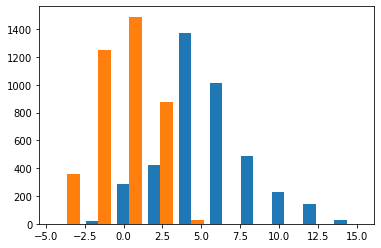

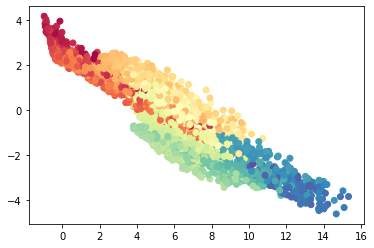

In [338]:
# First, create "results" folder at current working directory
model = train_dgi(new_data,512, 2, 2, patience=20,
              epochs=200, lr=1e-3, name_file="1")
plt.hist(model.get_embedding(new_data).numpy())
plt.figure()
out = model.get_embedding(new_data).numpy()
u = out
plt.scatter(u[:,0], u[:,1], c = t, 
            cmap="Spectral")
plt.show()

In [339]:
from numbers import Number
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from models.aggregation import GAPPNP
class GNN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int,
                 output_dim: int, n_layers: int,
                 activation: str='relu', slope: float=.1,
                 device: str='cpu',
                 alpha_res: float=0, alpha: float=0.5,
                 beta: float=1., gnn_type: str = 'symmetric',
                 norm: str='normalize',
                 must_propagate=None,
                 lambd_corr: float = 0):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.gnn_type = gnn_type
        self.n_layers = n_layers
        self.device = device
        self.alpha_res = alpha_res
        self.alpha = alpha
        self.beta= beta
        self.must_propagate = must_propagate
        self.propagate = GAPPNP(K=1, alpha_res=self.alpha_res,
                                alpha = self.alpha,
                                gnn_type=self.gnn_type,
                                beta = self.beta)
        self.norm = norm
        if self.must_propagate is None:
            self.must_propagate = [True] * self.n_layers
        if isinstance(hidden_dim, Number):
            self.hidden_dim = [hidden_dim] * (self.n_layers - 1)
        elif isinstance(hidden_dim, list):
            self.hidden_dim = hidden_dim
        else:
            raise ValueError('Wrong argument type for hidden_dim: {}'.format(hidden_dim))

        if isinstance(activation, str):
            self.activation = [activation] * (self.n_layers - 1)
        elif isinstance(activation, list):
            self.hidden_dim = activation
        else:
            raise ValueError('Wrong argument type for activation: {}'.format(activation))

        self._act_f = []
        for act in self.activation:
            if act == 'lrelu':
                self._act_f.append(lambda x: F.leaky_relu(x, negative_slope=slope))
            elif act == 'relu':
                self._act_f.append(lambda x: torch.nn.ReLU()(x))
            elif act == 'xtanh':
                self._act_f.append(lambda x: self.xtanh(x, alpha=slope))
            elif act == 'sigmoid':
                self._act_f.append(F.sigmoid)
            elif act == 'none':
                self._act_f.append(lambda x: x)
            else:
                ValueError('Incorrect activation: {}'.format(act))

        if self.n_layers == 1:
            _fc_list = [nn.Linear(self.input_dim, self.output_dim)]
        else:
            _fc_list = [nn.Linear(self.input_dim, self.hidden_dim[0])]
            for i in range(1, self.n_layers - 1):
                _fc_list.append(nn.Linear(self.hidden_dim[i - 1], self.hidden_dim[i]))
            _fc_list.append(nn.Linear(self.hidden_dim[self.n_layers - 2], self.output_dim))
        self.fc = nn.ModuleList(_fc_list)
        self.to(self.device)

    @staticmethod
    def xtanh(x, alpha=.1):
        """tanh function plus an additional linear term"""
        return x.tanh() + alpha * x

    def forward(self, x, edge_index):
        h = x
        for c in range(self.n_layers):
            if c == self.n_layers - 1:
                h = self.fc[c](h)
                if self.norm == 'normalize' and c==0:
                    h = F.normalize(h, p=2, dim=1)
                elif self.norm == 'standardize'and c==0:
                    h = (h - h.mean(0)) / h.std(0)
                elif self.norm == 'uniform'and c==0:
                    h = 1 * (h - h.min()) / (h.max() - h.min())
                elif self.norm == 'col_uniform'and c==0:
                    h = 1 * (h - h.min(0)[0].reshape([1,-1]))/ (h.max(0)[0].reshape([1,-1])-h.min(0)[0].reshape([1,-1]))

            else:
                h = self.fc[c](h)
                h = F.dropout(h, p=0.5, training=self.training)
                if self.must_propagate[c]:
                    h = self.propagate(h, edge_index)
                if self.norm == 'normalize':
                    h = F.normalize(h, p=2, dim=1)
                elif self.norm == 'standardize':
                    h = (h - h.mean(0)) / h.std(0) #z1 = (h1 - h1.mean(0)) / h1.std(0)
                elif self.norm == 'uniform':
                    h = 1 * (h - h.min()) / (h.max() - h.min())
                elif self.norm == 'col_uniform':
                    h = 1 * (h - h.min(0)[0].reshape([1,-1]))/ (h.max(0)[0].reshape([1,-1])-h.min(0)[0].reshape([1,-1]))
                h = self._act_f[c](h)
        if self.norm == 'standardize_last':
            h = (h - h.mean(0)) / h.std(0)
        return h


# GNUMAP

densmap reference: https://www.biorxiv.org/content/10.1101/2020.05.12.077776v1.full.pdf
$ L^{denseMAP} = CE(P||Q) - \lambda Corr(r_o^{UMAP}, r_e^{UMAP}) $

In [340]:
if torch_geometric.utils.is_undirected(new_data.edge_index):
    new_edge_index, new_edge_attr = new_data.edge_index, new_data.edge_weight
else:
    new_edge_index, new_edge_attr = torch_geometric.utils.to_undirected(new_data.edge_index, new_data.edge_weight)

#### transform edge index into knn matrix
knn = []
for i in range(new_data.num_nodes):
    knn += [list(np.sort(list(new_edge_attr[(new_edge_index[0]==i) & (new_edge_index[1]!=i )].numpy())))]
knn_dists = pd.DataFrame(knn).fillna(0).values
sigmas, rhos = smooth_knn_dist(
        knn_dists,
        float(15),
        local_connectivity=float(1),
         )
vals = [ np.exp(-(np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0])) /
                (sigmas[new_edge_index[0,i]])) for i in range(len(new_edge_attr))]

high = []
for i in range(new_data.num_nodes):
    high.append(
        np.insert((new_edge_attr[(new_edge_index[0]==i) & (new_edge_index[1]!=i )].numpy())/new_edge_attr[(new_edge_index[0] == i) & (new_edge_index[1] != i)].sum().numpy(),0,0)
    )
highs  = np.hstack(high)

#print(np.where(vals > 1e5))
rows = new_edge_index[0,:].numpy()
cols = new_edge_index[1,:].numpy()
vals = np.array(vals)
vals[vals<1e-5] = 0
result = scipy.sparse.coo_matrix(
    (highs, (rows, cols)), shape=(X.shape[0], X.shape[0])
)
result.eliminate_zeros()
target_graph_index, target_graph_weights = from_scipy_sparse_matrix(result)


In [341]:
vals.sum()

9154.671921255129

In [342]:
import numpy as np
from carbontracker.tracker import CarbonTracker
import cProfile
import os
import scipy
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops, negative_sampling
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils import to_scipy_sparse_matrix, to_networkx, from_scipy_sparse_matrix
import time
from umap_functions import *

def train_gnumap(data, hid_dim, dim, n_layers=2, target=None,
                 method = 'laplacian', must_propagate=None,
                 norm='normalize', neighbours=15,
                 patience=20, epochs=200, lr=1e-3, wd=1e-2,
                 min_dist=0.1, name_file="1", subsampling=None,
                 alpha: float=0.5, spread = 1.0, lambd_corr=1e-2,
                 beta: float=1., gnn_type: str = 'symmetric',
                 repulsion_strength=None,
                 local_connectivity=1,
                 device=None, colours=None):


    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    EPS_0 = data.num_edges/ (data.num_nodes ** 2)
    _a, _b = find_ab_params(spread, min_dist) # spread , min_dist given as hyperparameter

    #if torch_geometric.utils.is_undirected(data.edge_index):
    #    new_edge_index, new_edge_attr = torch_geometric.utils.to_undirected(data.edge_index, data.edge_weight)
    #else:
    #    new_edge_index, new_edge_attr = data.edge_index, data.edge_weight

    if torch_geometric.utils.is_undirected(data.edge_index):
        new_edge_index, new_edge_attr = data.edge_index, data.edge_weight
    else:
        new_edge_index, new_edge_attr = torch_geometric.utils.to_undirected(data.edge_index, data.edge_weight)

    #### transform edge index into knn matrix
    knn = []
    for i in range(data.num_nodes):
        knn += [list(np.sort(list(new_edge_attr[(new_edge_index[0]==i) & (new_edge_index[1]!=i )].numpy())))]
    knn_dists = pd.DataFrame(knn).fillna(0).values
    sigmas, rhos = smooth_knn_dist(
            knn_dists,
            float(neighbours),
            local_connectivity=float(local_connectivity),
             )

    # Maybe use the distance as the original distribution?
    vals = [ np.exp(-(np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0])) /
                    (sigmas[new_edge_index[0,i]])) for i in range(len(new_edge_attr))]

    #print(np.where(vals > 1e5))
    rows = new_edge_index[0,:].numpy()
    cols = new_edge_index[1,:].numpy()
    vals = np.array(vals)
    vals[vals<1e-5] = 0

    high = []
    for i in range(data.num_nodes):
        high.append(
            np.insert((new_edge_attr[(new_edge_index[0]==i) & (new_edge_index[1]!=i )].numpy())/new_edge_attr[(new_edge_index[0] == i) & (new_edge_index[1] != i)].sum().numpy(),0,0)
        )
    # highs = np.hstack(high)
    highs  = new_edge_attr/data.num_edges
    p =[]
    for i in range(data.num_nodes):
        p.append(
            highs[(new_edge_index[0] == i) & (new_edge_index[1] != i)].sum().numpy()
        )
    eta = data.edge_weight
    for i in range(len(data.edge_weight)):
        eta[i] = (p[data.edge_index[0,i]]+p[data.edge_index[1,i]])/2*data.x.shape[0]

    result = scipy.sparse.coo_matrix(
  #      (vals, (rows, cols)), shape=(X.shape[0], X.shape[0])
         (highs, (rows, cols)), shape=(X.shape[0], X.shape[0])
    )
    result.eliminate_zeros()
    target_graph_index, target_graph_weights = from_scipy_sparse_matrix(result)



    #### Prune
    EPS = 1e-29 #math.exp(-1.0/(2*_b) * math.log(1.0/_a * (1.0/EPS_0 -1)))
    print("Epsilon is " + str(EPS))
    print("Hyperparameters a = " + str(_a) + " and b = " + str(_b))



    model = GNN(data.num_features, hid_dim, dim, n_layers=n_layers,
                must_propagate=must_propagate,
                norm=norm)
    model = model.to(device)
    model.apply(init_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                             weight_decay=wd)
    new_data = Data(x=data.x, edge_index=target_graph_index,
                    y=data.y, edge_weight=target_graph_weights)
    sparsity =  new_data.num_edges/(new_data.num_nodes**2 -new_data.num_nodes)
    if repulsion_strength is None:
        repulsion_strength = 1.0/sparsity
        # we have way more samples that are "not" connected(sparsity), so need to give more weight to negative sampling to get balanced results
    row_pos, col_pos =  new_data.edge_index
    index = (row_pos != col_pos)
        # to exclude self-connectivity
    edge_weights_pos = new_data.edge_weight#[index]

    if target is not None:
        edge_weights_pos = fast_intersection(row_pos[index], col_pos[index], edge_weights_pos,
                                             target, unknown_dist=1.0, far_dist=5.0)
        # p_{ij}
    if subsampling is None:
        row_neg, col_neg = negative_sampling(new_data.edge_index, num_neg_samples = 5 * new_data.edge_index.shape[1] )
        # m = 5
        index_neg = (row_neg != col_neg)
        # edge_weights_neg = EPS * torch.ones(len(row_neg))
        edge_weights_neg = m*torch.ones(len(row_neg))
        if target is not None:
            edge_weights_neg = fast_intersection(row_neg[index_neg], col_neg[index_neg], edge_weights_neg,
                                                 target, unknown_dist=1.0, far_dist=5.0)
    best_t=0
    cnt_wait = 0
    best=1e9
    log_sigmoid = torch.nn.LogSigmoid()
    edges = [(e[0],e[1]) for _, e in enumerate(data.edge_index.numpy().T)]
    for epoch in range(epochs):
        tic_epoch = time.time()
        model.train()
        optimizer.zero_grad()
        tic = time.time()
        out = model(data.x.float(), data.edge_index)
        diff_norm = torch.sum(torch.square(out[row_pos[index]] - out[col_pos[index]]), 1)
        diff_norm = torch.clip(diff_norm, min=1e-3)
        log_q = - torch.log1p(_a *  diff_norm ** _b) # 1/(1+a*d^2b)
        # log_q = - torch.log1p(1+ diff_norm)
        loss_pos = - torch.mean(edge_weights_pos[index] * log_sigmoid(log_q)) - torch.mean((1. - edge_weights_pos[index]) *  (log_sigmoid(log_q) - log_q ) * repulsion_strength)
        # log(q/(q+1))


        if subsampling is None:
            diff_norm_neg = torch.sum(torch.square(out[row_neg[index_neg]] - out[col_neg[index_neg]]), 1) #+ 1e-3
            diff_norm_neg = torch.clip(diff_norm_neg, min=1e-3)
            log_q_neg = - torch.log1p(_a *  diff_norm_neg ** _b)
            # log_q_neg = - torch.log1p(1+ diff_norm_neg)
        else:
            row_neg, col_neg = negative_sampling(new_data.edge_index,
                                                 num_neg_samples=subsampling)
            index_neg = (row_neg != col_neg)
            edge_weights_neg = EPS * torch.ones(len(row_neg))
            if target is not None:
                edge_weights_neg = fast_intersection(row_neg[index_neg],
                                                     col_neg[index_neg], edge_weights_neg,
                                                     target, unknown_dist=1.0, far_dist=5.0)
            diff_norm_neg = torch.sum(torch.square(out[row_neg[index_neg]] - out[col_neg[index_neg]]), 1) #+ 1e-3
            diff_norm_neg = torch.clip(diff_norm_neg, min=1e-3)
            log_q_neg = - torch.log1p(_a *  diff_norm_neg ** _b)
            # log_q_neg = - torch.log1p(1+ diff_norm_neg)
        print("loss before neg", loss_pos)
        loss_neg = - torch.mean((log_sigmoid(log_q_neg) - log_q_neg ) * repulsion_strength)
        print("loss after neg", loss_neg)
        ### Add a term to make sure that the features are learned independently
        c1 = torch.mm(out.T, out)
        c1 = c1 / out.shape[0]
        iden = torch.tensor(np.eye(out.shape[1])).to(device)
        loss_dec1 = (torch.diag_embed(c1) - c1).pow(2).sum()
        loss = loss_pos + loss_neg +  lambd_corr * loss_dec1
        print("loss corr", lambd_corr * loss_dec1)
        print("loss final", loss)
        tic =  time.time()
        loss.backward()
        #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=4)
        optimizer.step()
        
        if epoch%10== 0:
            u = out.detach().numpy()
            plt.figure()
            plt.scatter(u[:,0], u[:,1], c = t, 
                        cmap="Spectral")
            plt.show()
            print(torch.mm(out.T, out)/ new_data.num_nodes)

        for g in optimizer.param_groups:
            g['lr'] = lr * (1.0 - (float(epoch) / float(epochs)))

        print('Epoch={:03d}, loss={:.4f}, time={:.4f}'.format(epoch, loss.item(),time.time()-tic_epoch))
        if loss < best:
            best = loss
            best_t = epoch
            cnt_wait = 0
            torch.save(model.state_dict(), os.getcwd()  + '/results/best_gnumap_'
                                          + str(method) + '_neigh' + str(neighbours)
                                          + '_dim' + str(dim) + '_' + name_file +  '.pkl')
        else:
            cnt_wait += 1
        if cnt_wait == patience and epoch>50:
            print('Early stopping at epoch {}!'.format(epoch))
            break
        #print("Time epoch after saving", time.time()-tic_epoch)
    #tracker.stop()
    print('Loading {}th epoch'.format(best_t))
    model.load_state_dict(torch.load(os.getcwd()  + '/results/best_gnumap_' +
                                     str(method) + '_neigh' + str(neighbours)
                                     + '_dim' + str(dim) + '_' + name_file + '.pkl'))
    return(model,target_graph_index, vals, knn_dists)

Epsilon is 1e-29
Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
loss before neg tensor(68.6742, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(68.1350, grad_fn=<NegBackward0>)
loss corr tensor(6.2700e-05, grad_fn=<MulBackward0>)
loss final tensor(136.8092, dtype=torch.float64, grad_fn=<AddBackward0>)


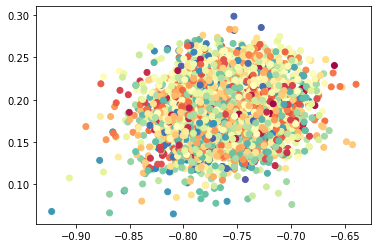

tensor([[ 0.5738, -0.1427],
        [-0.1427,  0.0367]], grad_fn=<DivBackward0>)
Epoch=000, loss=136.8092, time=1.8014
loss before neg tensor(30.7439, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(29.6231, grad_fn=<NegBackward0>)
loss corr tensor(4.9065, grad_fn=<MulBackward0>)
loss final tensor(65.2735, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=001, loss=65.2735, time=1.1937
loss before neg tensor(25.7649, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(23.6696, grad_fn=<NegBackward0>)
loss corr tensor(17.9519, grad_fn=<MulBackward0>)
loss final tensor(67.3864, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=002, loss=67.3864, time=0.9669
loss before neg tensor(23.0225, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(18.9205, grad_fn=<NegBackward0>)
loss corr tensor(9.6475, grad_fn=<MulBackward0>)
loss final tensor(51.5905, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=003, loss=51.5905, time=0.8156
loss befor

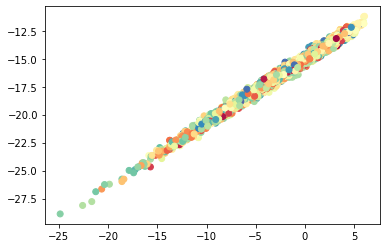

tensor([[ 20.6392,  31.5889],
        [ 31.5889, 256.7406]], grad_fn=<DivBackward0>)
Epoch=010, loss=35.7955, time=0.9709
loss before neg tensor(19.3176, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(11.7182, grad_fn=<NegBackward0>)
loss corr tensor(5.8356, grad_fn=<MulBackward0>)
loss final tensor(36.8714, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=011, loss=36.8714, time=0.8025
loss before neg tensor(19.3683, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(11.7592, grad_fn=<NegBackward0>)
loss corr tensor(5.5100, grad_fn=<MulBackward0>)
loss final tensor(36.6375, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=012, loss=36.6375, time=0.8133
loss before neg tensor(18.7938, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(11.0256, grad_fn=<NegBackward0>)
loss corr tensor(2.7226, grad_fn=<MulBackward0>)
loss final tensor(32.5421, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=013, loss=32.5421, time=0.8596
loss bef

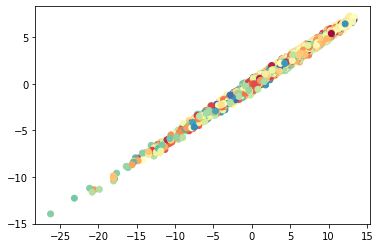

tensor([[47.7873, 25.2152],
        [25.2152, 13.3842]], grad_fn=<DivBackward0>)
Epoch=020, loss=27.1757, time=1.2464
loss before neg tensor(17.4927, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(9.2749, grad_fn=<NegBackward0>)
loss corr tensor(0.4153, grad_fn=<MulBackward0>)
loss final tensor(27.1830, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=021, loss=27.1830, time=0.8792
loss before neg tensor(16.7075, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.2181, grad_fn=<NegBackward0>)
loss corr tensor(0.2469, grad_fn=<MulBackward0>)
loss final tensor(25.1725, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=022, loss=25.1725, time=0.8189
loss before neg tensor(17.3896, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.8261, grad_fn=<NegBackward0>)
loss corr tensor(0.6233, grad_fn=<MulBackward0>)
loss final tensor(26.8389, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=023, loss=26.8389, time=0.8104
loss before neg

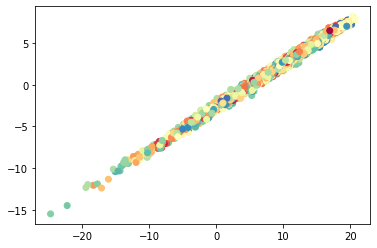

tensor([[139.1849,  45.6919],
        [ 45.6919,  17.3270]], grad_fn=<DivBackward0>)
Epoch=030, loss=26.4493, time=1.0288
loss before neg tensor(16.4344, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.2640, grad_fn=<NegBackward0>)
loss corr tensor(3.3739, grad_fn=<MulBackward0>)
loss final tensor(28.0723, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=031, loss=28.0723, time=0.8676
loss before neg tensor(17.0241, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.6139, grad_fn=<NegBackward0>)
loss corr tensor(1.1823, grad_fn=<MulBackward0>)
loss final tensor(26.8203, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=032, loss=26.8203, time=0.8281
loss before neg tensor(16.1651, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(7.7574, grad_fn=<NegBackward0>)
loss corr tensor(0.5182, grad_fn=<MulBackward0>)
loss final tensor(24.4407, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=033, loss=24.4407, time=0.7987
loss before

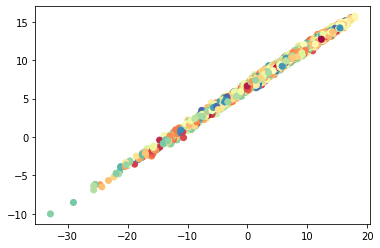

tensor([[ 81.4301,  77.6018],
        [ 77.6018, 101.1712]], grad_fn=<DivBackward0>)
Epoch=040, loss=26.0631, time=1.0346
loss before neg tensor(16.5569, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.1338, grad_fn=<NegBackward0>)
loss corr tensor(3.1755, grad_fn=<MulBackward0>)
loss final tensor(27.8662, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=041, loss=27.8662, time=0.8867
loss before neg tensor(15.6429, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(7.0446, grad_fn=<NegBackward0>)
loss corr tensor(0.5799, grad_fn=<MulBackward0>)
loss final tensor(23.2674, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=042, loss=23.2674, time=0.9528
loss before neg tensor(16.1551, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(7.5205, grad_fn=<NegBackward0>)
loss corr tensor(0.3409, grad_fn=<MulBackward0>)
loss final tensor(24.0166, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=043, loss=24.0166, time=1.0219
loss before

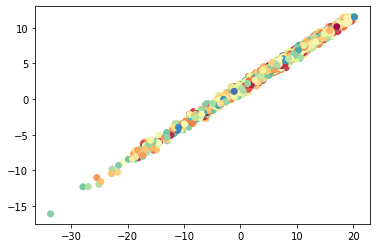

tensor([[120.1956,  71.7712],
        [ 71.7712,  44.0856]], grad_fn=<DivBackward0>)
Epoch=050, loss=24.6212, time=1.0778
loss before neg tensor(15.8950, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(7.2129, grad_fn=<NegBackward0>)
loss corr tensor(3.2692, grad_fn=<MulBackward0>)
loss final tensor(26.3771, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=051, loss=26.3771, time=0.8953
loss before neg tensor(15.2189, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.6895, grad_fn=<NegBackward0>)
loss corr tensor(0.6104, grad_fn=<MulBackward0>)
loss final tensor(22.5189, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=052, loss=22.5189, time=0.9440
loss before neg tensor(15.5702, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(7.0598, grad_fn=<NegBackward0>)
loss corr tensor(0.4583, grad_fn=<MulBackward0>)
loss final tensor(23.0884, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=053, loss=23.0884, time=0.8435
loss before

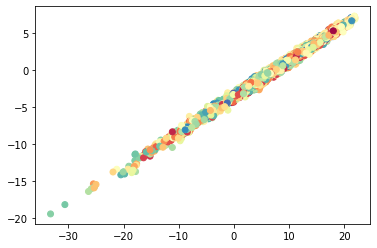

tensor([[134.5800,  34.8059],
        [ 34.8059,  15.2180]], grad_fn=<DivBackward0>)
Epoch=060, loss=23.6466, time=1.3933
loss before neg tensor(14.5911, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.0598, grad_fn=<NegBackward0>)
loss corr tensor(1.3337, grad_fn=<MulBackward0>)
loss final tensor(21.9846, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=061, loss=21.9846, time=1.0684
loss before neg tensor(14.4125, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(5.9098, grad_fn=<NegBackward0>)
loss corr tensor(0.8732, grad_fn=<MulBackward0>)
loss final tensor(21.1956, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=062, loss=21.1956, time=1.1160
loss before neg tensor(14.6487, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.2292, grad_fn=<NegBackward0>)
loss corr tensor(0.6937, grad_fn=<MulBackward0>)
loss final tensor(21.5716, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=063, loss=21.5716, time=1.0439
loss before

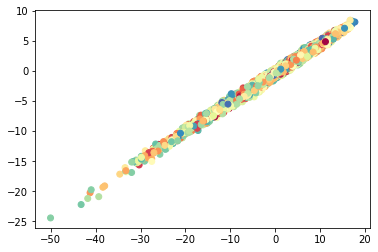

tensor([[90.3943, 43.2761],
        [43.2761, 21.0840]], grad_fn=<DivBackward0>)
Epoch=070, loss=20.6176, time=1.0628
loss before neg tensor(14.3386, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(5.9270, grad_fn=<NegBackward0>)
loss corr tensor(1.1906, grad_fn=<MulBackward0>)
loss final tensor(21.4562, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=071, loss=21.4562, time=0.8262
loss before neg tensor(14.1450, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(5.7584, grad_fn=<NegBackward0>)
loss corr tensor(1.2768, grad_fn=<MulBackward0>)
loss final tensor(21.1802, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=072, loss=21.1802, time=0.8392
loss before neg tensor(14.3864, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.0330, grad_fn=<NegBackward0>)
loss corr tensor(1.7595, grad_fn=<MulBackward0>)
loss final tensor(22.1789, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=073, loss=22.1789, time=0.8346
loss before neg

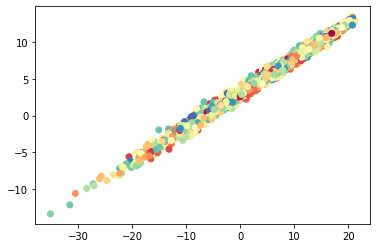

tensor([[123.3416,  80.8233],
        [ 80.8233,  58.3417]], grad_fn=<DivBackward0>)
Epoch=080, loss=24.0493, time=1.2088
loss before neg tensor(14.5784, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.4636, grad_fn=<NegBackward0>)
loss corr tensor(1.7616, grad_fn=<MulBackward0>)
loss final tensor(22.8036, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=081, loss=22.8036, time=0.8862
loss before neg tensor(14.5063, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.4927, grad_fn=<NegBackward0>)
loss corr tensor(0.5354, grad_fn=<MulBackward0>)
loss final tensor(21.5344, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=082, loss=21.5344, time=0.8240
loss before neg tensor(15.1497, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(7.0635, grad_fn=<NegBackward0>)
loss corr tensor(0.5528, grad_fn=<MulBackward0>)
loss final tensor(22.7660, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=083, loss=22.7660, time=0.8214
loss before

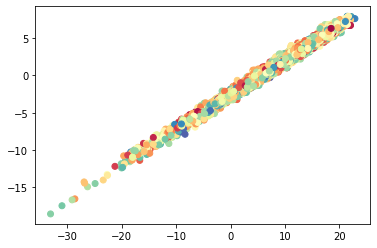

tensor([[147.8901,  46.1414],
        [ 46.1414,  17.7023]], grad_fn=<DivBackward0>)
Epoch=090, loss=22.5611, time=1.0038
Early stopping at epoch 90!
Loading 70th epoch


<Figure size 432x288 with 0 Axes>

(array([[4.000e+00, 2.000e+00, 2.500e+01, 5.000e+01, 1.730e+02, 3.110e+02,
         7.050e+02, 1.058e+03, 1.211e+03, 4.610e+02],
        [0.000e+00, 0.000e+00, 5.000e+00, 2.900e+01, 2.870e+02, 1.210e+03,
         2.333e+03, 1.360e+02, 0.000e+00, 0.000e+00]]),
 array([-33.61787415, -27.55410957, -21.490345  , -15.42658043,
         -9.36281586,  -3.29905128,   2.76471329,   8.82847786,
         14.89224243,  20.956007  ,  27.01977158]),
 <a list of 2 BarContainer objects>)

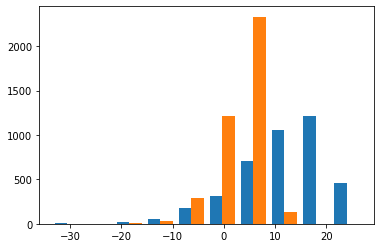

<Figure size 432x288 with 0 Axes>

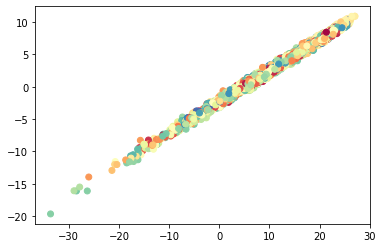

tensor([[211.4813,  73.9554],
        [ 73.9554,  27.9199]], grad_fn=<DivBackward0>)


In [343]:
model2, target_graph_index, vals, knn_dists=  train_gnumap(new_data, 
                                     target=None, hid_dim=1054, dim=2, 
                                     n_layers=3, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5, 
                                     gnn_type='symmetric', repulsion_strength=100,
                                     norm='uniform', neighbours=5,
                                      beta=1, patience=20, epochs=1000,
                                      lr=1e-1, 
                                    wd=1e-4,
                                    lambd_corr=1e-4,
                                       min_dist=0.01,
                       subsampling=100000)
out = model2(new_data.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t, 
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

(array([7.7210e+03, 1.2385e+04, 2.5470e+03, 5.4500e+02, 1.8300e+02,
        9.6000e+01, 2.1000e+01, 1.9000e+01, 1.7000e+01, 6.0000e+00]),
 array([0.2486843 , 0.80824663, 1.36780897, 1.92737131, 2.48693365,
        3.04649599, 3.60605833, 4.16562067, 4.725183  , 5.28474534,
        5.84430768]),
 <BarContainer object of 10 artists>)

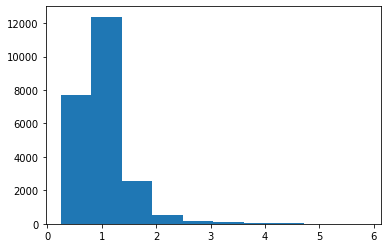

In [344]:
plt.hist(new_data.edge_weight)

(array([1.5006e+04, 2.6000e+02, 1.2500e+02, 7.4000e+01, 2.9000e+01,
        1.3000e+01, 1.8000e+01, 1.1000e+01, 2.0000e+00, 8.0020e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

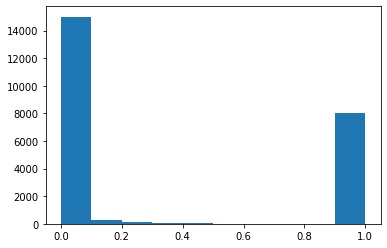

In [345]:
plt.hist(vals)

In [346]:
len(vals)

23540

In [347]:
new_edge_index, new_edge_attr = remove_self_loops(new_data.edge_index, new_data.edge_weight)

In [348]:
knn_dists
sigmas, rhos = smooth_knn_dist(
            knn_dists,
            float(2),
            local_connectivity=float(1.),
             )

array([[0.16588158, 0.769747  , 0.99240464, ..., 0.        , 0.        ,
        0.        ],
       [0.58171387, 0.68507409, 0.88650212, ..., 0.        , 0.        ,
        0.        ],
       [0.86801983, 1.35242392, 1.49870726, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [2.08382413, 2.08873409, 2.1607619 , ..., 0.        , 0.        ,
        0.        ],
       [0.51816169, 1.04270442, 1.13215294, ..., 0.        , 0.        ,
        0.        ],
       [2.4633596 , 2.50182186, 2.54278379, ..., 0.        , 0.        ,
        0.        ]])

In [349]:
vals = []
for i in range(len(new_edge_attr))[:100]:
    vals+= [ np.exp(-(np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0])) /
                    (sigmas[new_edge_index[0,i]]))]
    print([i, np.exp(-(np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0])) /
                    (sigmas[new_edge_index[0,i]]))])

[0, 0.0]
[1, 0.0]
[2, 0.0]
[3, 0.0]
[4, 1.9630180849328772e-136]
[5, 2.03893896413816e-11]
[6, 4.549440841866543e-111]
[7, 8.437012920617429e-69]
[8, 4.632363441970312e-26]
[9, 9.540004927970268e-25]
[10, 1.8555071976744263e-114]
[11, 4.960264843237792e-72]
[12, 8.568372217399387e-91]
[13, 3.2283911028304826e-65]
[14, 1.0]
[15, 6.175822136922864e-37]
[16, 5.577671061964951e-194]
[17, 1.0]
[18, 1.1401020670699339e-302]
[19, 1.05358e-318]
[20, 5.445355174443903e-224]
[21, 3.561265769084921e-196]
[22, 3.77196823369618e-301]
[23, 0.0]
[24, 3.1527057730460006e-39]
[25, 2.399870992086285e-180]
[26, 8.646735887845859e-263]
[27, 1.0]
[28, 0.0]
[29, 2.936527176701982e-197]
[30, 0.0]
[31, 2.18098554797e-313]
[32, 0.0]
[33, 0.0]
[34, 1.0]
[35, 1.129407274347394e-188]
[36, 7.018711505110567e-121]
[37, 7.153360507372023e-289]
[38, 6.691268921321594e-32]
[39, 3.117692500332012e-92]
[40, 5.142240586224407e-134]
[41, 9.17394218549449e-51]
[42, 3.444123132311714e-49]
[43, 1.2949936871230065e-81]
[44, 1

In [350]:
i = 5
print(new_edge_index[:,i], new_edge_attr.numpy()[i] , rhos[new_edge_index[0,i]], sigmas[new_edge_index[0,i]])
print(np.max(new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0)/sigmas[new_edge_index[0,i]])

tensor([   1, 1494]) 0.5939216849302463 0.58171386 0.00049593055
24.616006466003974


In [351]:
np.max([new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0]
      )

0.012207829663675285

In [352]:
np.max(new_edge_attr.numpy()[i] - rhos[new_edge_index[0,i]], 0)/sigmas[new_edge_index[0,i]]

24.616006466003974

(array([1.185e+03, 2.154e+03, 4.850e+02, 1.200e+02, 2.900e+01, 1.500e+01,
        6.000e+00, 5.000e+00, 0.000e+00, 1.000e+00]),
 array([0.0428946 , 0.57098633, 1.09907806, 1.62716985, 2.15526152,
        2.68335319, 3.21144509, 3.73953676, 4.26762867, 4.7957201 ,
        5.32381201]),
 <BarContainer object of 10 artists>)

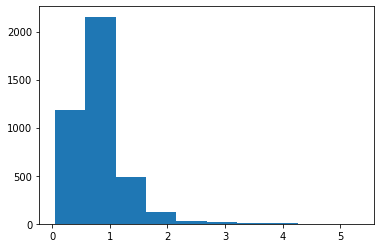

In [353]:
plt.hist(rhos)

Epsilon is 1e-29
Hyperparameters a = 1.929073396421303 and b = 0.7915045335007013
loss before neg tensor(0.6673, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2433, grad_fn=<NegBackward0>)
loss corr tensor(3.2029, grad_fn=<MulBackward0>)
loss final tensor(4.1135, dtype=torch.float64, grad_fn=<AddBackward0>)


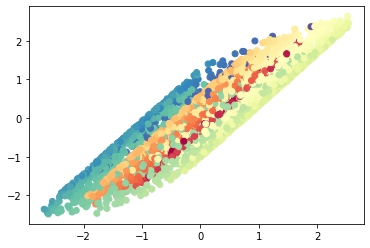

tensor([[0.9998, 0.8916],
        [0.8916, 0.9998]], grad_fn=<DivBackward0>)
Epoch=000, loss=4.1135, time=0.2915
loss before neg tensor(0.6673, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2412, grad_fn=<NegBackward0>)
loss corr tensor(3.0970, grad_fn=<MulBackward0>)
loss final tensor(4.0055, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=001, loss=4.0055, time=0.1182
loss before neg tensor(0.6673, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2391, grad_fn=<NegBackward0>)
loss corr tensor(2.9879, grad_fn=<MulBackward0>)
loss final tensor(3.8944, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=002, loss=3.8944, time=0.1220
loss before neg tensor(0.6673, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2366, grad_fn=<NegBackward0>)
loss corr tensor(2.8769, grad_fn=<MulBackward0>)
loss final tensor(3.7808, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=003, loss=3.7808, time=0.1151
loss before neg tensor(0.6673

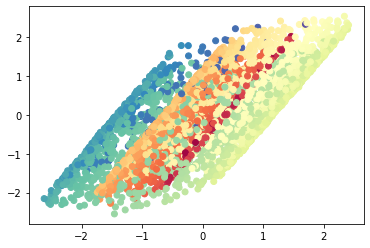

tensor([[0.9998, 0.6954],
        [0.6954, 0.9998]], grad_fn=<DivBackward0>)
Epoch=010, loss=3.0104, time=0.2872
loss before neg tensor(0.6675, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2216, grad_fn=<NegBackward0>)
loss corr tensor(2.0247, grad_fn=<MulBackward0>)
loss final tensor(2.9137, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=011, loss=2.9137, time=0.1287
loss before neg tensor(0.6675, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2201, grad_fn=<NegBackward0>)
loss corr tensor(1.9350, grad_fn=<MulBackward0>)
loss final tensor(2.8226, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=012, loss=2.8226, time=0.1149
loss before neg tensor(0.6675, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2180, grad_fn=<NegBackward0>)
loss corr tensor(1.8511, grad_fn=<MulBackward0>)
loss final tensor(2.7367, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=013, loss=2.7367, time=0.1259
loss before neg tensor(0.6676

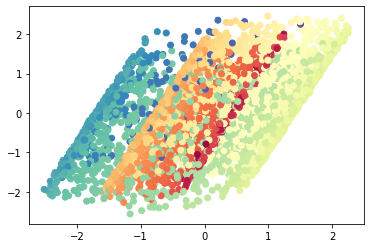

tensor([[0.9997, 0.4726],
        [0.4726, 0.9997]], grad_fn=<DivBackward0>)
Epoch=020, loss=2.3291, time=0.2980
loss before neg tensor(0.6677, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2109, grad_fn=<NegBackward0>)
loss corr tensor(1.4180, grad_fn=<MulBackward0>)
loss final tensor(2.2965, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=021, loss=2.2965, time=0.1228
loss before neg tensor(0.6678, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2103, grad_fn=<NegBackward0>)
loss corr tensor(1.3925, grad_fn=<MulBackward0>)
loss final tensor(2.2705, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=022, loss=2.2705, time=0.1154
loss before neg tensor(0.6678, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2098, grad_fn=<NegBackward0>)
loss corr tensor(1.3723, grad_fn=<MulBackward0>)
loss final tensor(2.2499, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=023, loss=2.2499, time=0.1152
loss before neg tensor(0.6678

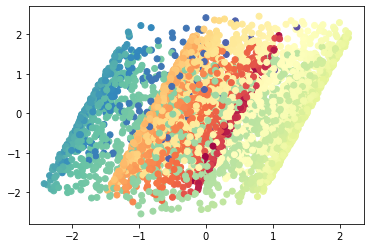

tensor([[0.9998, 0.3134],
        [0.3134, 0.9998]], grad_fn=<DivBackward0>)
Epoch=030, loss=2.2100, time=0.3267
loss before neg tensor(0.6679, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2070, grad_fn=<NegBackward0>)
loss corr tensor(1.3380, grad_fn=<MulBackward0>)
loss final tensor(2.2129, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=031, loss=2.2129, time=0.1214
loss before neg tensor(0.6680, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2059, grad_fn=<NegBackward0>)
loss corr tensor(1.3415, grad_fn=<MulBackward0>)
loss final tensor(2.2154, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=032, loss=2.2154, time=0.1162
loss before neg tensor(0.6680, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2069, grad_fn=<NegBackward0>)
loss corr tensor(1.3452, grad_fn=<MulBackward0>)
loss final tensor(2.2201, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=033, loss=2.2201, time=0.1186
loss before neg tensor(0.6680

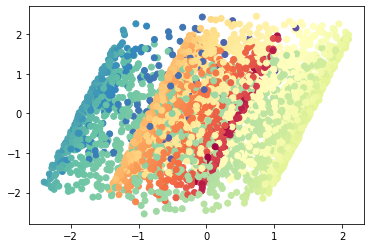

tensor([[0.9998, 0.2657],
        [0.2657, 0.9998]], grad_fn=<DivBackward0>)
Epoch=040, loss=2.2346, time=0.2944
loss before neg tensor(0.6680, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2073, grad_fn=<NegBackward0>)
loss corr tensor(1.3596, grad_fn=<MulBackward0>)
loss final tensor(2.2349, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=041, loss=2.2349, time=0.1326
loss before neg tensor(0.6680, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2071, grad_fn=<NegBackward0>)
loss corr tensor(1.3586, grad_fn=<MulBackward0>)
loss final tensor(2.2337, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=042, loss=2.2337, time=0.1174
loss before neg tensor(0.6680, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2058, grad_fn=<NegBackward0>)
loss corr tensor(1.3571, grad_fn=<MulBackward0>)
loss final tensor(2.2309, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=043, loss=2.2309, time=0.1130
loss before neg tensor(0.6680

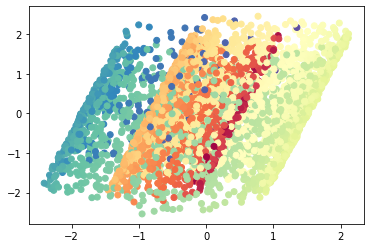

tensor([[0.9998, 0.2939],
        [0.2939, 0.9997]], grad_fn=<DivBackward0>)
Epoch=050, loss=2.2169, time=0.3074
loss before neg tensor(0.6679, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2071, grad_fn=<NegBackward0>)
loss corr tensor(1.3401, grad_fn=<MulBackward0>)
loss final tensor(2.2152, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=051, loss=2.2152, time=0.1201
loss before neg tensor(0.6679, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2067, grad_fn=<NegBackward0>)
loss corr tensor(1.3384, grad_fn=<MulBackward0>)
loss final tensor(2.2130, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=052, loss=2.2130, time=0.1147
loss before neg tensor(0.6679, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2075, grad_fn=<NegBackward0>)
loss corr tensor(1.3369, grad_fn=<MulBackward0>)
loss final tensor(2.2124, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=053, loss=2.2124, time=0.1198
loss before neg tensor(0.6679

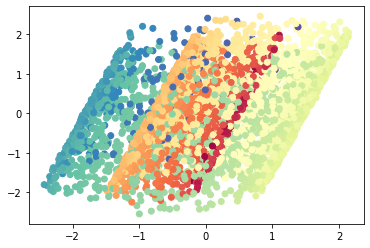

tensor([[0.9998, 0.3318],
        [0.3318, 0.9998]], grad_fn=<DivBackward0>)
Epoch=060, loss=2.2081, time=0.2919
loss before neg tensor(0.6679, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2076, grad_fn=<NegBackward0>)
loss corr tensor(1.3327, grad_fn=<MulBackward0>)
loss final tensor(2.2082, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=061, loss=2.2082, time=0.1265
loss before neg tensor(0.6679, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2079, grad_fn=<NegBackward0>)
loss corr tensor(1.3327, grad_fn=<MulBackward0>)
loss final tensor(2.2085, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=062, loss=2.2085, time=0.1153
loss before neg tensor(0.6679, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2081, grad_fn=<NegBackward0>)
loss corr tensor(1.3329, grad_fn=<MulBackward0>)
loss final tensor(2.2088, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=063, loss=2.2088, time=0.1133
loss before neg tensor(0.6679

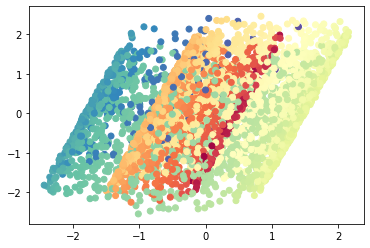

tensor([[0.9998, 0.3455],
        [0.3455, 0.9997]], grad_fn=<DivBackward0>)
Epoch=070, loss=2.2094, time=0.2945
loss before neg tensor(0.6679, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2075, grad_fn=<NegBackward0>)
loss corr tensor(1.3336, grad_fn=<MulBackward0>)
loss final tensor(2.2089, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=071, loss=2.2089, time=0.1294
loss before neg tensor(0.6679, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2081, grad_fn=<NegBackward0>)
loss corr tensor(1.3335, grad_fn=<MulBackward0>)
loss final tensor(2.2095, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=072, loss=2.2095, time=0.1164
loss before neg tensor(0.6679, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2081, grad_fn=<NegBackward0>)
loss corr tensor(1.3335, grad_fn=<MulBackward0>)
loss final tensor(2.2095, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=073, loss=2.2095, time=0.1159
loss before neg tensor(0.6679

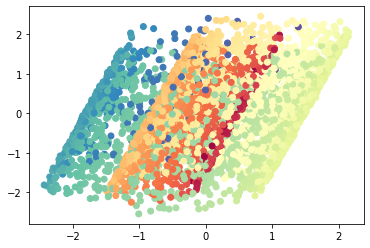

tensor([[0.9998, 0.3393],
        [0.3393, 0.9997]], grad_fn=<DivBackward0>)
Epoch=080, loss=2.2085, time=0.2984
Early stopping at epoch 80!
Loading 60th epoch


ValueError: too many values to unpack (expected 2)

In [354]:
#xx = torch.ones((X.shape[0], 10))
new_data3 = copy.deepcopy(new_data)
# new_data2.x =  new_data.x[:,:2] # leave out z-axis
model2, target_index =  train_gnumap(new_data3,
                                     target=None, hid_dim=256, dim=2, 
                                     n_layers=1, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5, 
                                     gnn_type='symmetric', repulsion_strength=1.,
                                     norm='standardize', neighbours=2,
                                    beta=1, patience=20, epochs=1000,
                                       lr=1e-2, 
                                       wd=1e-4,
                                        lambd_corr=1.,
                                       min_dist=0.001,
                       subsampling=100000)
out = model2(new_data3.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t, 
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

Epsilon is 1e-29
Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
loss before neg tensor(68.4342, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(67.7537, grad_fn=<NegBackward0>)
loss corr tensor(1.0854e-06, grad_fn=<MulBackward0>)
loss final tensor(136.1879, dtype=torch.float64, grad_fn=<AddBackward0>)


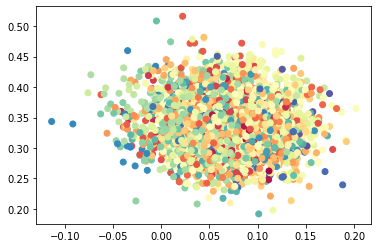

tensor([[0.0064, 0.0233],
        [0.0233, 0.1149]], grad_fn=<DivBackward0>)
Epoch=000, loss=136.1879, time=0.8128
loss before neg tensor(38.4192, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(38.2854, grad_fn=<NegBackward0>)
loss corr tensor(3.1254, grad_fn=<MulBackward0>)
loss final tensor(79.8300, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=001, loss=79.8300, time=0.5191
loss before neg tensor(26.6535, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(25.4771, grad_fn=<NegBackward0>)
loss corr tensor(12.2618, grad_fn=<MulBackward0>)
loss final tensor(64.3923, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=002, loss=64.3923, time=0.5011
loss before neg tensor(24.6782, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(21.5161, grad_fn=<NegBackward0>)
loss corr tensor(2.0741, grad_fn=<MulBackward0>)
loss final tensor(48.2684, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=003, loss=48.2684, time=0.4935
loss before ne

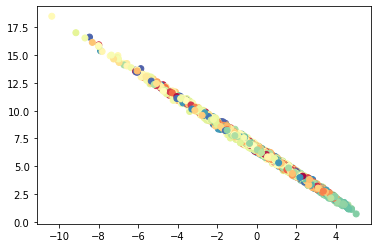

tensor([[ 5.4398, -0.5714],
        [-0.5714, 38.0183]], grad_fn=<DivBackward0>)
Epoch=010, loss=38.0768, time=0.7210
loss before neg tensor(22.5326, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(16.1834, grad_fn=<NegBackward0>)
loss corr tensor(0.3147, grad_fn=<MulBackward0>)
loss final tensor(39.0308, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=011, loss=39.0308, time=0.5520
loss before neg tensor(21.6586, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(15.8009, grad_fn=<NegBackward0>)
loss corr tensor(7.0386, grad_fn=<MulBackward0>)
loss final tensor(44.4981, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=012, loss=44.4981, time=0.5048
loss before neg tensor(21.5369, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(15.4031, grad_fn=<NegBackward0>)
loss corr tensor(9.6039, grad_fn=<MulBackward0>)
loss final tensor(46.5440, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=013, loss=46.5440, time=0.8932
loss before 

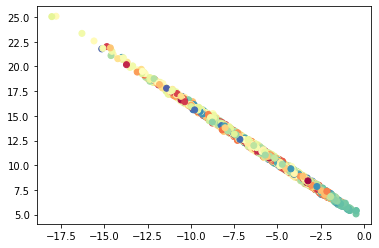

tensor([[ 30.8293, -58.3926],
        [-58.3926, 114.6111]], grad_fn=<DivBackward0>)
Epoch=020, loss=40.6868, time=0.7049
loss before neg tensor(20.8446, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(14.2552, grad_fn=<NegBackward0>)
loss corr tensor(10.2047, grad_fn=<MulBackward0>)
loss final tensor(45.3045, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=021, loss=45.3045, time=0.5120
loss before neg tensor(21.2474, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(15.5271, grad_fn=<NegBackward0>)
loss corr tensor(7.5739, grad_fn=<MulBackward0>)
loss final tensor(44.3483, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=022, loss=44.3483, time=0.5111
loss before neg tensor(20.7358, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(15.1569, grad_fn=<NegBackward0>)
loss corr tensor(5.3160, grad_fn=<MulBackward0>)
loss final tensor(41.2086, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=023, loss=41.2086, time=0.5085
loss be

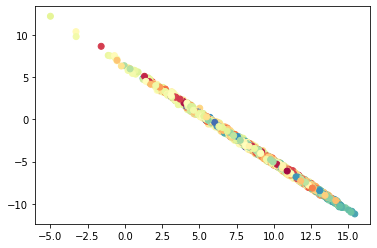

tensor([[104.4679, -56.8262],
        [-56.8262,  33.8741]], grad_fn=<DivBackward0>)
Epoch=030, loss=38.1065, time=0.7811
loss before neg tensor(20.0363, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(12.9990, grad_fn=<NegBackward0>)
loss corr tensor(2.0337, grad_fn=<MulBackward0>)
loss final tensor(35.0690, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=031, loss=35.0690, time=0.5592
loss before neg tensor(19.6841, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(12.7609, grad_fn=<NegBackward0>)
loss corr tensor(0.8722, grad_fn=<MulBackward0>)
loss final tensor(33.3172, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=032, loss=33.3172, time=0.5364
loss before neg tensor(19.5535, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(12.2634, grad_fn=<NegBackward0>)
loss corr tensor(1.3274, grad_fn=<MulBackward0>)
loss final tensor(33.1443, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=033, loss=33.1443, time=0.5422
loss bef

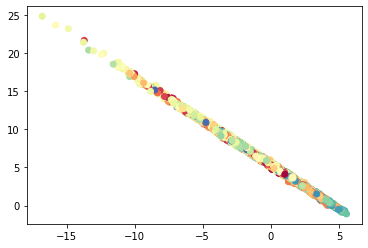

tensor([[  9.8981, -13.2418],
        [-13.2418,  46.0351]], grad_fn=<DivBackward0>)
Epoch=040, loss=31.3992, time=0.9244
loss before neg tensor(19.1580, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(11.9511, grad_fn=<NegBackward0>)
loss corr tensor(0.2857, grad_fn=<MulBackward0>)
loss final tensor(31.3948, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=041, loss=31.3948, time=0.5824
loss before neg tensor(18.3312, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(10.7310, grad_fn=<NegBackward0>)
loss corr tensor(0.8880, grad_fn=<MulBackward0>)
loss final tensor(29.9502, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=042, loss=29.9502, time=0.5400
loss before neg tensor(18.2100, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(10.7672, grad_fn=<NegBackward0>)
loss corr tensor(0.5768, grad_fn=<MulBackward0>)
loss final tensor(29.5540, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=043, loss=29.5540, time=0.5076
loss bef

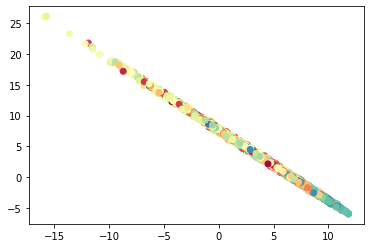

tensor([[31.9993, -5.0627],
        [-5.0627, 28.4142]], grad_fn=<DivBackward0>)
Epoch=050, loss=27.9391, time=1.4710
loss before neg tensor(17.3739, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(9.9126, grad_fn=<NegBackward0>)
loss corr tensor(0.2490, grad_fn=<MulBackward0>)
loss final tensor(27.5355, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=051, loss=27.5355, time=1.2598
loss before neg tensor(18.0911, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(10.5183, grad_fn=<NegBackward0>)
loss corr tensor(0.5479, grad_fn=<MulBackward0>)
loss final tensor(29.1574, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=052, loss=29.1574, time=0.7142
loss before neg tensor(17.2776, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(9.7094, grad_fn=<NegBackward0>)
loss corr tensor(0.3090, grad_fn=<MulBackward0>)
loss final tensor(27.2960, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=053, loss=27.2960, time=0.5252
loss before ne

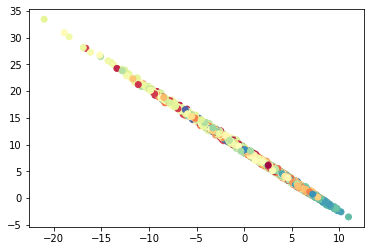

tensor([[20.4721, -8.0563],
        [-8.0563, 72.3380]], grad_fn=<DivBackward0>)
Epoch=060, loss=26.9646, time=0.6960
loss before neg tensor(17.0674, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(9.7498, grad_fn=<NegBackward0>)
loss corr tensor(0.5404, grad_fn=<MulBackward0>)
loss final tensor(27.3576, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=061, loss=27.3576, time=0.5201
loss before neg tensor(17.2774, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(9.7442, grad_fn=<NegBackward0>)
loss corr tensor(0.2838, grad_fn=<MulBackward0>)
loss final tensor(27.3054, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=062, loss=27.3054, time=0.5192
loss before neg tensor(16.8397, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(9.1903, grad_fn=<NegBackward0>)
loss corr tensor(0.5158, grad_fn=<MulBackward0>)
loss final tensor(26.5459, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=063, loss=26.5459, time=0.5187
loss before neg

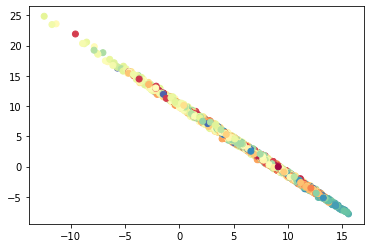

tensor([[74.2838, -7.3803],
        [-7.3803, 23.1004]], grad_fn=<DivBackward0>)
Epoch=070, loss=27.7497, time=0.6894
loss before neg tensor(17.0501, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(9.2454, grad_fn=<NegBackward0>)
loss corr tensor(0.3859, grad_fn=<MulBackward0>)
loss final tensor(26.6814, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=071, loss=26.6814, time=0.5290
loss before neg tensor(16.5628, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.8957, grad_fn=<NegBackward0>)
loss corr tensor(0.4089, grad_fn=<MulBackward0>)
loss final tensor(25.8674, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=072, loss=25.8674, time=0.5082
loss before neg tensor(16.8689, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(9.0410, grad_fn=<NegBackward0>)
loss corr tensor(0.4614, grad_fn=<MulBackward0>)
loss final tensor(26.3713, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=073, loss=26.3713, time=0.5134
loss before neg

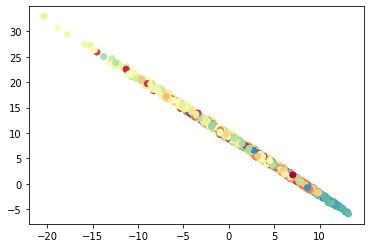

tensor([[35.6204, -4.7662],
        [-4.7662, 52.3626]], grad_fn=<DivBackward0>)
Epoch=080, loss=25.2321, time=0.7018
loss before neg tensor(16.9930, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(9.0421, grad_fn=<NegBackward0>)
loss corr tensor(0.3902, grad_fn=<MulBackward0>)
loss final tensor(26.4252, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=081, loss=26.4252, time=0.5082
loss before neg tensor(16.3730, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.2737, grad_fn=<NegBackward0>)
loss corr tensor(0.5250, grad_fn=<MulBackward0>)
loss final tensor(25.1716, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=082, loss=25.1716, time=0.4954
loss before neg tensor(16.8082, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.7755, grad_fn=<NegBackward0>)
loss corr tensor(0.4533, grad_fn=<MulBackward0>)
loss final tensor(26.0369, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=083, loss=26.0369, time=0.4998
loss before neg

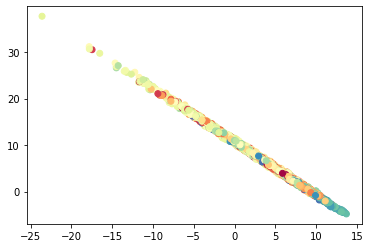

tensor([[38.4907, -0.9278],
        [-0.9278, 67.4921]], grad_fn=<DivBackward0>)
Epoch=090, loss=25.0375, time=0.7393
loss before neg tensor(16.5860, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.8622, grad_fn=<NegBackward0>)
loss corr tensor(0.5671, grad_fn=<MulBackward0>)
loss final tensor(26.0153, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=091, loss=26.0153, time=0.5487
loss before neg tensor(16.4041, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.6453, grad_fn=<NegBackward0>)
loss corr tensor(0.4344, grad_fn=<MulBackward0>)
loss final tensor(25.4839, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=092, loss=25.4839, time=0.5199
loss before neg tensor(16.0987, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.7903, grad_fn=<NegBackward0>)
loss corr tensor(0.5156, grad_fn=<MulBackward0>)
loss final tensor(25.4045, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=093, loss=25.4045, time=0.5153
loss before neg

<Figure size 432x288 with 0 Axes>

(array([[   6.,   36.,  203.,  688., 1724., 1322.,   21.,    0.,    0.,
            0.],
        [   0.,    0.,    4.,  804., 1716.,  968.,  368.,  116.,   18.,
            6.]]),
 array([-19.67037582, -14.46852684,  -9.26667881,  -4.06482983,
          1.13701856,   6.33886719,  11.54071617,  16.74256516,
         21.94441223,  27.14626122,  32.3481102 ]),
 <a list of 2 BarContainer objects>)

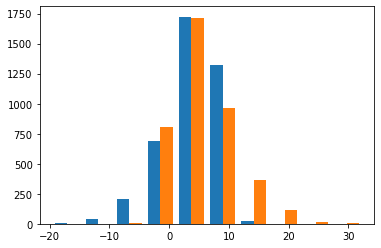

<Figure size 432x288 with 0 Axes>

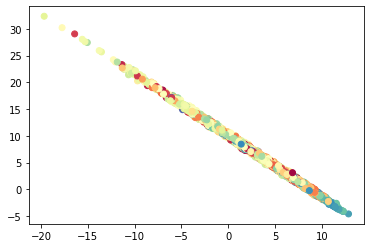

tensor([[36.0380, -1.5464],
        [-1.5464, 57.1180]], grad_fn=<DivBackward0>)


In [355]:
new_data4 = copy.deepcopy(new_data)
model2, target_graph_index, vals, knn_dists=  train_gnumap(new_data4,
                                     target=None, hid_dim=512, dim=2,
                                     n_layers=3, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=100,
                                     norm='uniform', neighbours=5,
                                      beta=1, patience=20, epochs=1000,
                                      lr=1e-1,
                                    wd=1e-4,
                                    lambd_corr=1e-4,
                                       min_dist=0.01,
                       subsampling=100000)
out = model2(new_data4.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

Epsilon is 1e-29
Hyperparameters a = 1.929073396421303 and b = 0.7915045335007013
loss before neg tensor(0.6694, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2087, grad_fn=<NegBackward0>)
loss corr tensor(4.1859, grad_fn=<MulBackward0>)
loss final tensor(5.0640, dtype=torch.float64, grad_fn=<AddBackward0>)


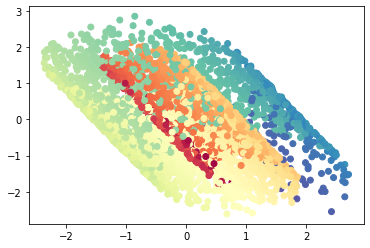

tensor([[ 0.9998, -0.3563],
        [-0.3563,  0.9998]], grad_fn=<DivBackward0>)
Epoch=000, loss=5.0640, time=0.3233
loss before neg tensor(0.6696, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2081, grad_fn=<NegBackward0>)
loss corr tensor(3.9531, grad_fn=<MulBackward0>)
loss final tensor(4.8308, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=001, loss=4.8308, time=0.1363
loss before neg tensor(0.6698, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2073, grad_fn=<NegBackward0>)
loss corr tensor(3.7300, grad_fn=<MulBackward0>)
loss final tensor(4.6071, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=002, loss=4.6071, time=0.1292
loss before neg tensor(0.6699, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2076, grad_fn=<NegBackward0>)
loss corr tensor(3.5173, grad_fn=<MulBackward0>)
loss final tensor(4.3948, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=003, loss=4.3948, time=0.1430
loss before neg tensor(0.

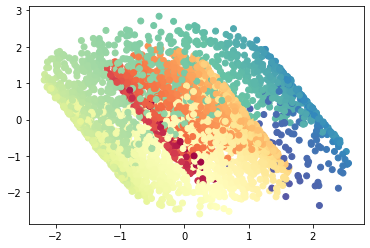

tensor([[ 0.9998, -0.0768],
        [-0.0768,  0.9997]], grad_fn=<DivBackward0>)
Epoch=010, loss=3.2176, time=0.3165
loss before neg tensor(0.6713, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2048, grad_fn=<NegBackward0>)
loss corr tensor(2.2187, grad_fn=<MulBackward0>)
loss final tensor(3.0948, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=011, loss=3.0948, time=0.1306
loss before neg tensor(0.6715, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2047, grad_fn=<NegBackward0>)
loss corr tensor(2.1063, grad_fn=<MulBackward0>)
loss final tensor(2.9825, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=012, loss=2.9825, time=0.1324
loss before neg tensor(0.6716, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2046, grad_fn=<NegBackward0>)
loss corr tensor(2.0041, grad_fn=<MulBackward0>)
loss final tensor(2.8804, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=013, loss=2.8804, time=0.1371
loss before neg tensor(0.

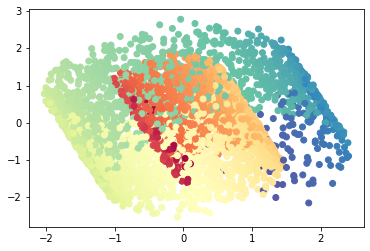

tensor([[0.9998, 0.1504],
        [0.1504, 0.9998]], grad_fn=<DivBackward0>)
Epoch=020, loss=2.4115, time=0.3591
loss before neg tensor(0.6727, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2061, grad_fn=<NegBackward0>)
loss corr tensor(1.4948, grad_fn=<MulBackward0>)
loss final tensor(2.3736, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=021, loss=2.3736, time=0.1356
loss before neg tensor(0.6728, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2055, grad_fn=<NegBackward0>)
loss corr tensor(1.4618, grad_fn=<MulBackward0>)
loss final tensor(2.3401, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=022, loss=2.3401, time=0.1290
loss before neg tensor(0.6729, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2058, grad_fn=<NegBackward0>)
loss corr tensor(1.4338, grad_fn=<MulBackward0>)
loss final tensor(2.3125, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=023, loss=2.3125, time=0.1409
loss before neg tensor(0.6730

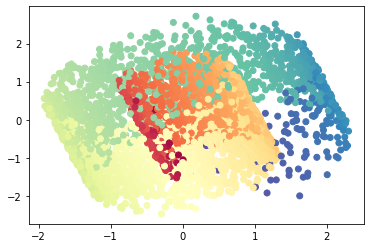

tensor([[0.9997, 0.2976],
        [0.2976, 0.9998]], grad_fn=<DivBackward0>)
Epoch=030, loss=2.2218, time=0.3195
loss before neg tensor(0.6736, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2072, grad_fn=<NegBackward0>)
loss corr tensor(1.3366, grad_fn=<MulBackward0>)
loss final tensor(2.2174, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=031, loss=2.2174, time=0.1341
loss before neg tensor(0.6737, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2083, grad_fn=<NegBackward0>)
loss corr tensor(1.3342, grad_fn=<MulBackward0>)
loss final tensor(2.2162, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=032, loss=2.2162, time=0.1310
loss before neg tensor(0.6737, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2086, grad_fn=<NegBackward0>)
loss corr tensor(1.3330, grad_fn=<MulBackward0>)
loss final tensor(2.2154, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=033, loss=2.2154, time=0.1442
loss before neg tensor(0.6738

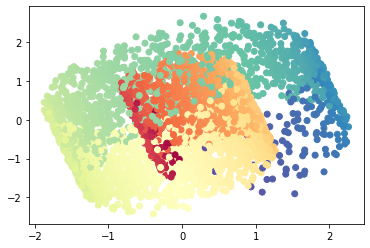

tensor([[0.9998, 0.3652],
        [0.3652, 0.9997]], grad_fn=<DivBackward0>)
Epoch=040, loss=2.2210, time=0.3185
loss before neg tensor(0.6740, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2093, grad_fn=<NegBackward0>)
loss corr tensor(1.3400, grad_fn=<MulBackward0>)
loss final tensor(2.2233, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=041, loss=2.2233, time=0.1315
loss before neg tensor(0.6740, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2088, grad_fn=<NegBackward0>)
loss corr tensor(1.3411, grad_fn=<MulBackward0>)
loss final tensor(2.2239, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=042, loss=2.2239, time=0.1300
loss before neg tensor(0.6740, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2084, grad_fn=<NegBackward0>)
loss corr tensor(1.3420, grad_fn=<MulBackward0>)
loss final tensor(2.2244, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=043, loss=2.2244, time=0.1349
loss before neg tensor(0.6740

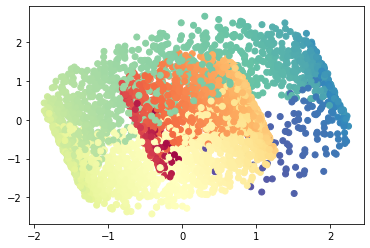

tensor([[0.9997, 0.3748],
        [0.3748, 0.9998]], grad_fn=<DivBackward0>)
Epoch=050, loss=2.2261, time=0.3129
loss before neg tensor(0.6740, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2080, grad_fn=<NegBackward0>)
loss corr tensor(1.3425, grad_fn=<MulBackward0>)
loss final tensor(2.2245, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=051, loss=2.2245, time=0.1349
loss before neg tensor(0.6740, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2088, grad_fn=<NegBackward0>)
loss corr tensor(1.3419, grad_fn=<MulBackward0>)
loss final tensor(2.2247, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=052, loss=2.2247, time=0.1274
loss before neg tensor(0.6740, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(0.2085, grad_fn=<NegBackward0>)
loss corr tensor(1.3412, grad_fn=<MulBackward0>)
loss final tensor(2.2238, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=053, loss=2.2238, time=0.1438
loss before neg tensor(0.6740

ValueError: too many values to unpack (expected 2)

In [356]:
#xx = torch.ones((X.shape[0], 10))
new_data5 = copy.deepcopy(new_data)
# new_data2.x =  new_data.x[:,:2] # leave out z-axis
model2, target_index =  train_gnumap(new_data5,
                                     target=None, hid_dim=512, dim=2,
                                     n_layers=1, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=1.,
                                     norm='standardize', neighbours=2,
                                    beta=1, patience=20, epochs=1000,
                                       lr=1e-2,
                                       wd=1e-4,
                                        lambd_corr=1.,
                                       min_dist=0.001,
                       subsampling=100000)
out = model2(new_data5.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

Epsilon is 1e-29
Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
loss before neg tensor(68.6366, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(67.8589, grad_fn=<NegBackward0>)
loss corr tensor(7.3991e-07, grad_fn=<MulBackward0>)
loss final tensor(136.4955, dtype=torch.float64, grad_fn=<AddBackward0>)


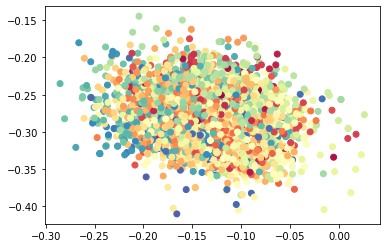

tensor([[0.0191, 0.0363],
        [0.0363, 0.0791]], grad_fn=<DivBackward0>)
Epoch=000, loss=136.4955, time=0.5288
loss before neg tensor(45.6617, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(45.1172, grad_fn=<NegBackward0>)
loss corr tensor(0.3688, grad_fn=<MulBackward0>)
loss final tensor(91.1477, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=001, loss=91.1477, time=0.2872
loss before neg tensor(32.4784, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(31.7412, grad_fn=<NegBackward0>)
loss corr tensor(3.5820, grad_fn=<MulBackward0>)
loss final tensor(67.8016, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=002, loss=67.8016, time=0.3104
loss before neg tensor(27.9128, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(26.3104, grad_fn=<NegBackward0>)
loss corr tensor(1.5067, grad_fn=<MulBackward0>)
loss final tensor(55.7299, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=003, loss=55.7299, time=0.2552
loss before neg

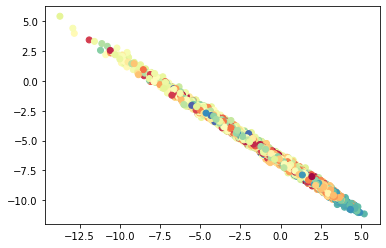

tensor([[ 8.5120, -5.4660],
        [-5.4660, 47.4235]], grad_fn=<DivBackward0>)
Epoch=010, loss=33.8049, time=0.4412
loss before neg tensor(17.8032, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(12.2032, grad_fn=<NegBackward0>)
loss corr tensor(0.0962, grad_fn=<MulBackward0>)
loss final tensor(30.1026, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=011, loss=30.1026, time=0.2739
loss before neg tensor(16.8117, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(11.0553, grad_fn=<NegBackward0>)
loss corr tensor(0.4548, grad_fn=<MulBackward0>)
loss final tensor(28.3217, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=012, loss=28.3217, time=0.2642
loss before neg tensor(16.8754, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(11.0309, grad_fn=<NegBackward0>)
loss corr tensor(0.3275, grad_fn=<MulBackward0>)
loss final tensor(28.2339, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=013, loss=28.2339, time=0.2602
loss before 

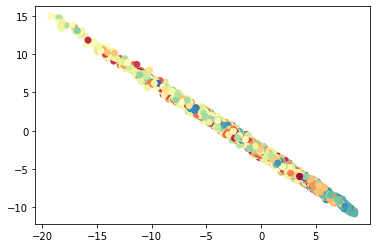

tensor([[ 22.6284, -20.3999],
        [-20.3999,  25.6468]], grad_fn=<DivBackward0>)
Epoch=020, loss=24.8310, time=0.4344
loss before neg tensor(15.3345, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.9353, grad_fn=<NegBackward0>)
loss corr tensor(0.7089, grad_fn=<MulBackward0>)
loss final tensor(24.9787, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=021, loss=24.9787, time=0.2902
loss before neg tensor(14.6893, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.6708, grad_fn=<NegBackward0>)
loss corr tensor(0.8153, grad_fn=<MulBackward0>)
loss final tensor(24.1754, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=022, loss=24.1754, time=0.2847
loss before neg tensor(13.9767, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(7.9841, grad_fn=<NegBackward0>)
loss corr tensor(1.9278, grad_fn=<MulBackward0>)
loss final tensor(23.8886, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=023, loss=23.8886, time=0.2684
loss before

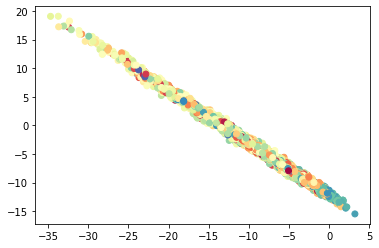

tensor([[115.1542,   3.2626],
        [  3.2626,  46.8506]], grad_fn=<DivBackward0>)
Epoch=030, loss=21.9618, time=0.4519
loss before neg tensor(13.0590, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(7.0115, grad_fn=<NegBackward0>)
loss corr tensor(4.5120, grad_fn=<MulBackward0>)
loss final tensor(24.5824, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=031, loss=24.5824, time=0.2648
loss before neg tensor(13.1447, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(7.3263, grad_fn=<NegBackward0>)
loss corr tensor(1.0267, grad_fn=<MulBackward0>)
loss final tensor(21.4978, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=032, loss=21.4978, time=0.2676
loss before neg tensor(13.3239, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(7.2639, grad_fn=<NegBackward0>)
loss corr tensor(1.4470, grad_fn=<MulBackward0>)
loss final tensor(22.0348, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=033, loss=22.0348, time=0.2621
loss before

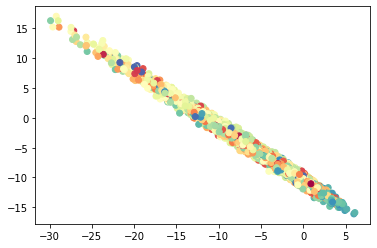

tensor([[63.2547, -2.0508],
        [-2.0508, 63.0619]], grad_fn=<DivBackward0>)
Epoch=040, loss=20.5689, time=0.4497
loss before neg tensor(12.6401, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.6922, grad_fn=<NegBackward0>)
loss corr tensor(2.5572, grad_fn=<MulBackward0>)
loss final tensor(21.8895, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=041, loss=21.8895, time=0.2670
loss before neg tensor(12.3380, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.6913, grad_fn=<NegBackward0>)
loss corr tensor(3.1542, grad_fn=<MulBackward0>)
loss final tensor(22.1836, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=042, loss=22.1836, time=0.2614
loss before neg tensor(13.1289, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(7.3021, grad_fn=<NegBackward0>)
loss corr tensor(3.8255, grad_fn=<MulBackward0>)
loss final tensor(24.2566, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=043, loss=24.2566, time=0.2612
loss before neg

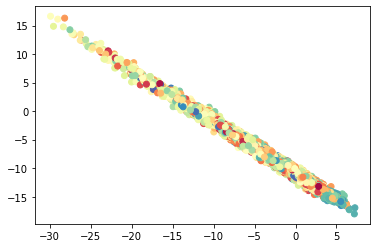

tensor([[55.9809, -4.2820],
        [-4.2820, 82.0431]], grad_fn=<DivBackward0>)
Epoch=050, loss=20.7706, time=0.5025
loss before neg tensor(12.6577, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.8033, grad_fn=<NegBackward0>)
loss corr tensor(2.7052, grad_fn=<MulBackward0>)
loss final tensor(22.1663, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=051, loss=22.1663, time=0.3001
loss before neg tensor(12.8526, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.7524, grad_fn=<NegBackward0>)
loss corr tensor(1.4111, grad_fn=<MulBackward0>)
loss final tensor(21.0161, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=052, loss=21.0161, time=0.3114
loss before neg tensor(12.9265, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.8569, grad_fn=<NegBackward0>)
loss corr tensor(0.9490, grad_fn=<MulBackward0>)
loss final tensor(20.7324, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=053, loss=20.7324, time=0.3300
loss before neg

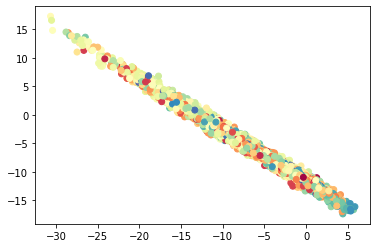

tensor([[67.8121,  2.4450],
        [ 2.4450, 77.5231]], grad_fn=<DivBackward0>)
Epoch=060, loss=20.2084, time=0.4473
loss before neg tensor(12.6409, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.7872, grad_fn=<NegBackward0>)
loss corr tensor(1.2163, grad_fn=<MulBackward0>)
loss final tensor(20.6443, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=061, loss=20.6443, time=0.2682
loss before neg tensor(12.1809, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.1646, grad_fn=<NegBackward0>)
loss corr tensor(3.9025, grad_fn=<MulBackward0>)
loss final tensor(22.2480, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=062, loss=22.2480, time=0.2788
loss before neg tensor(12.6723, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.7688, grad_fn=<NegBackward0>)
loss corr tensor(1.0370, grad_fn=<MulBackward0>)
loss final tensor(20.4780, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=063, loss=20.4780, time=0.2706
loss before neg

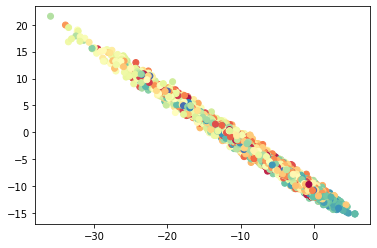

tensor([[97.9586, -7.9530],
        [-7.9530, 52.8899]], grad_fn=<DivBackward0>)
Epoch=070, loss=19.5478, time=0.4623
loss before neg tensor(11.9055, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.2043, grad_fn=<NegBackward0>)
loss corr tensor(1.3786, grad_fn=<MulBackward0>)
loss final tensor(19.4883, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=071, loss=19.4883, time=0.2675
loss before neg tensor(12.1069, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.3216, grad_fn=<NegBackward0>)
loss corr tensor(2.9633, grad_fn=<MulBackward0>)
loss final tensor(21.3918, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=072, loss=21.3918, time=0.2641
loss before neg tensor(11.4649, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(5.6799, grad_fn=<NegBackward0>)
loss corr tensor(1.6937, grad_fn=<MulBackward0>)
loss final tensor(18.8385, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=073, loss=18.8385, time=0.2633
loss before neg

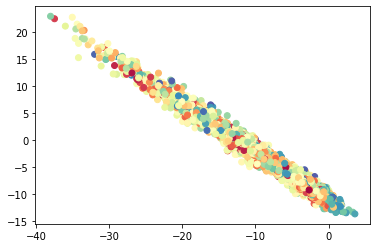

tensor([[122.6714, -11.8732],
        [-11.8732,  48.7542]], grad_fn=<DivBackward0>)
Epoch=080, loss=19.3109, time=0.4413
loss before neg tensor(11.5402, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.2985, grad_fn=<NegBackward0>)
loss corr tensor(1.3532, grad_fn=<MulBackward0>)
loss final tensor(19.1920, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=081, loss=19.1920, time=0.2745
loss before neg tensor(11.5667, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.1669, grad_fn=<NegBackward0>)
loss corr tensor(1.9953, grad_fn=<MulBackward0>)
loss final tensor(19.7290, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=082, loss=19.7290, time=0.2803
loss before neg tensor(11.5671, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.0241, grad_fn=<NegBackward0>)
loss corr tensor(2.9759, grad_fn=<MulBackward0>)
loss final tensor(20.5671, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=083, loss=20.5671, time=0.2678
loss before

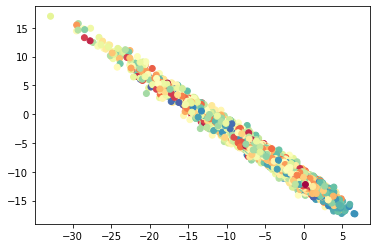

tensor([[62.3930,  1.1770],
        [ 1.1770, 80.4721]], grad_fn=<DivBackward0>)
Epoch=090, loss=19.3737, time=0.4523
loss before neg tensor(11.3111, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(5.7949, grad_fn=<NegBackward0>)
loss corr tensor(2.9314, grad_fn=<MulBackward0>)
loss final tensor(20.0374, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=091, loss=20.0374, time=0.2728
loss before neg tensor(11.4339, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(5.8542, grad_fn=<NegBackward0>)
loss corr tensor(4.7493, grad_fn=<MulBackward0>)
loss final tensor(22.0374, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=092, loss=22.0374, time=0.2566
loss before neg tensor(11.3509, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(5.9626, grad_fn=<NegBackward0>)
loss corr tensor(1.1591, grad_fn=<MulBackward0>)
loss final tensor(18.4725, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=093, loss=18.4725, time=0.2620
loss before neg

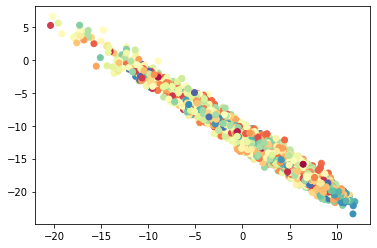

tensor([[ 35.6663, -61.9758],
        [-61.9758, 212.8694]], grad_fn=<DivBackward0>)
Epoch=100, loss=29.6451, time=0.4381
loss before neg tensor(12.5334, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(7.0036, grad_fn=<NegBackward0>)
loss corr tensor(19.6589, grad_fn=<MulBackward0>)
loss final tensor(39.1959, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=101, loss=39.1959, time=0.2889
loss before neg tensor(12.6212, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(7.2706, grad_fn=<NegBackward0>)
loss corr tensor(0.6588, grad_fn=<MulBackward0>)
loss final tensor(20.5507, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=102, loss=20.5507, time=0.2694
loss before neg tensor(12.3115, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.9793, grad_fn=<NegBackward0>)
loss corr tensor(7.3865, grad_fn=<MulBackward0>)
loss final tensor(26.6773, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=103, loss=26.6773, time=0.2627
loss befor

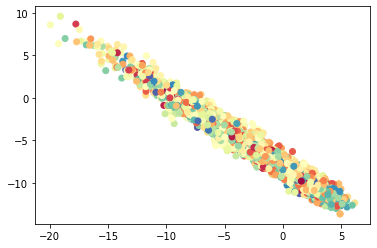

tensor([[19.4496, -6.6528],
        [-6.6528, 62.0324]], grad_fn=<DivBackward0>)
Epoch=110, loss=23.6914, time=0.4555
loss before neg tensor(14.4913, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(9.5293, grad_fn=<NegBackward0>)
loss corr tensor(0.1661, grad_fn=<MulBackward0>)
loss final tensor(24.1867, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=111, loss=24.1867, time=0.2739
loss before neg tensor(14.3116, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(9.1666, grad_fn=<NegBackward0>)
loss corr tensor(0.2620, grad_fn=<MulBackward0>)
loss final tensor(23.7403, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=112, loss=23.7403, time=0.2642
loss before neg tensor(14.0937, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(8.9045, grad_fn=<NegBackward0>)
loss corr tensor(1.4194, grad_fn=<MulBackward0>)
loss final tensor(24.4176, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=113, loss=24.4176, time=0.2596
Early stopping 

<Figure size 432x288 with 0 Axes>

(array([[   3.,   14.,   44.,  100.,  209.,  388.,  667.,  903., 1225.,
          447.],
        [   0.,  273., 1367., 1028.,  664.,  386.,  169.,   84.,   21.,
            8.]]),
 array([-25.99014854, -22.29630852, -18.60246658, -14.90862656,
        -11.21478558,  -7.5209446 ,  -3.82710385,  -0.13326302,
          3.56057787,   7.25441837,  10.94825935]),
 <a list of 2 BarContainer objects>)

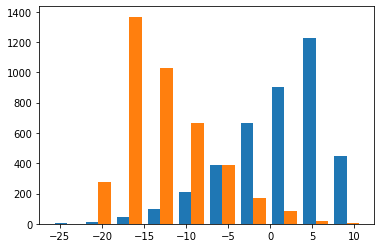

<Figure size 432x288 with 0 Axes>

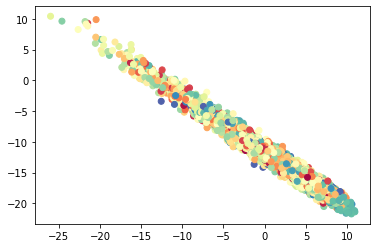

tensor([[ 35.2870, -43.8505],
        [-43.8505, 186.2733]], grad_fn=<DivBackward0>)


In [357]:
new_data6 = copy.deepcopy(new_data)
model2, target_graph_index, vals, knn_dists=  train_gnumap(new_data6,
                                     target=None, hid_dim=256, dim=2,
                                     n_layers=3, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=100,
                                     norm='uniform', neighbours=5,
                                      beta=1, patience=20, epochs=1000,
                                      lr=1e-1,
                                    wd=1e-4,
                                    lambd_corr=1e-4,
                                       min_dist=0.01,
                       subsampling=100000)
out = model2(new_data6.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

Epsilon is 1e-29
Hyperparameters a = 1.89560586638432 and b = 0.8006378440415777
loss before neg tensor(34.1588, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(33.6122, grad_fn=<NegBackward0>)
loss corr tensor(3.5533e-07, grad_fn=<MulBackward0>)
loss final tensor(67.7710, dtype=torch.float64, grad_fn=<AddBackward0>)


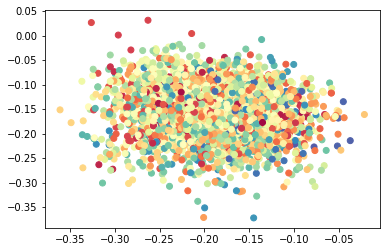

tensor([[0.0385, 0.0294],
        [0.0294, 0.0270]], grad_fn=<DivBackward0>)
Epoch=000, loss=67.7710, time=0.8091
loss before neg tensor(21.2885, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(21.2217, grad_fn=<NegBackward0>)
loss corr tensor(0.3619, grad_fn=<MulBackward0>)
loss final tensor(42.8720, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=001, loss=42.8720, time=0.4178
loss before neg tensor(15.7529, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(15.6162, grad_fn=<NegBackward0>)
loss corr tensor(2.6728, grad_fn=<MulBackward0>)
loss final tensor(34.0419, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=002, loss=34.0419, time=0.3776
loss before neg tensor(14.1894, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(13.3478, grad_fn=<NegBackward0>)
loss corr tensor(0.8907, grad_fn=<MulBackward0>)
loss final tensor(28.4278, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=003, loss=28.4278, time=0.3905
loss before neg 

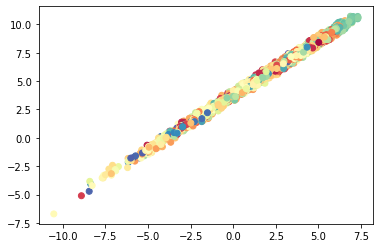

tensor([[14.8660, 24.4164],
        [24.4164, 47.2211]], grad_fn=<DivBackward0>)
Epoch=010, loss=17.1821, time=0.5918
loss before neg tensor(9.1247, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(6.3579, grad_fn=<NegBackward0>)
loss corr tensor(0.1405, grad_fn=<MulBackward0>)
loss final tensor(15.6230, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=011, loss=15.6230, time=0.3429
loss before neg tensor(8.8665, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(5.9186, grad_fn=<NegBackward0>)
loss corr tensor(0.0398, grad_fn=<MulBackward0>)
loss final tensor(14.8250, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=012, loss=14.8250, time=0.3257
loss before neg tensor(8.6887, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(5.8296, grad_fn=<NegBackward0>)
loss corr tensor(0.0461, grad_fn=<MulBackward0>)
loss final tensor(14.5644, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=013, loss=14.5644, time=0.3402
loss before neg te

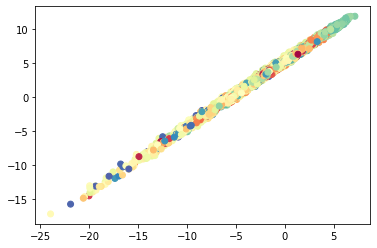

tensor([[24.2980, 15.4408],
        [15.4408, 34.8892]], grad_fn=<DivBackward0>)
Epoch=020, loss=12.3420, time=0.5017
loss before neg tensor(7.4131, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(4.2703, grad_fn=<NegBackward0>)
loss corr tensor(0.1562, grad_fn=<MulBackward0>)
loss final tensor(11.8396, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=021, loss=11.8396, time=0.2824
loss before neg tensor(7.7172, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(4.5952, grad_fn=<NegBackward0>)
loss corr tensor(0.9159, grad_fn=<MulBackward0>)
loss final tensor(13.2283, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=022, loss=13.2283, time=0.2954
loss before neg tensor(7.4964, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(4.3793, grad_fn=<NegBackward0>)
loss corr tensor(0.4478, grad_fn=<MulBackward0>)
loss final tensor(12.3235, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=023, loss=12.3235, time=0.2800
loss before neg te

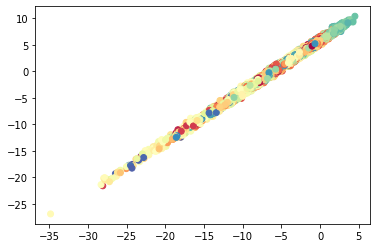

tensor([[62.6262, 27.5040],
        [27.5040, 29.3313]], grad_fn=<DivBackward0>)
Epoch=030, loss=11.1433, time=0.5698
loss before neg tensor(6.8376, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.5865, grad_fn=<NegBackward0>)
loss corr tensor(0.5440, grad_fn=<MulBackward0>)
loss final tensor(10.9681, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=031, loss=10.9681, time=0.3422
loss before neg tensor(6.9988, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.7771, grad_fn=<NegBackward0>)
loss corr tensor(0.2676, grad_fn=<MulBackward0>)
loss final tensor(11.0434, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=032, loss=11.0434, time=0.3391
loss before neg tensor(6.7949, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.6252, grad_fn=<NegBackward0>)
loss corr tensor(0.3328, grad_fn=<MulBackward0>)
loss final tensor(10.7529, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=033, loss=10.7529, time=0.3404
loss before neg te

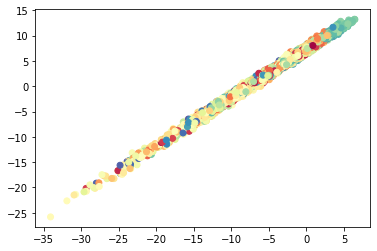

tensor([[62.2889, 24.3606],
        [24.3606, 43.4501]], grad_fn=<DivBackward0>)
Epoch=040, loss=10.1364, time=0.5055
loss before neg tensor(6.6388, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.5489, grad_fn=<NegBackward0>)
loss corr tensor(0.5262, grad_fn=<MulBackward0>)
loss final tensor(10.7139, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=041, loss=10.7139, time=0.3186
loss before neg tensor(6.2793, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.1675, grad_fn=<NegBackward0>)
loss corr tensor(0.5837, grad_fn=<MulBackward0>)
loss final tensor(10.0306, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=042, loss=10.0306, time=0.3912
loss before neg tensor(6.3128, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.1976, grad_fn=<NegBackward0>)
loss corr tensor(0.5053, grad_fn=<MulBackward0>)
loss final tensor(10.0157, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=043, loss=10.0157, time=0.2870
loss before neg te

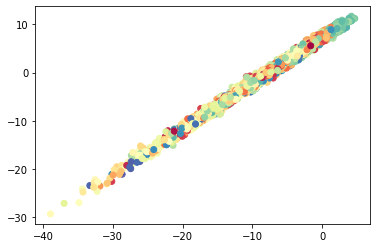

tensor([[93.4979, 38.3277],
        [38.3277, 41.2364]], grad_fn=<DivBackward0>)
Epoch=050, loss=9.9933, time=0.4460
loss before neg tensor(6.0692, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.0806, grad_fn=<NegBackward0>)
loss corr tensor(4.1742, grad_fn=<MulBackward0>)
loss final tensor(13.3240, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=051, loss=13.3240, time=0.3162
loss before neg tensor(6.2737, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.2537, grad_fn=<NegBackward0>)
loss corr tensor(0.4925, grad_fn=<MulBackward0>)
loss final tensor(10.0200, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=052, loss=10.0200, time=0.3299
loss before neg tensor(6.3169, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.3580, grad_fn=<NegBackward0>)
loss corr tensor(0.4613, grad_fn=<MulBackward0>)
loss final tensor(10.1362, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=053, loss=10.1362, time=0.2656
loss before neg ten

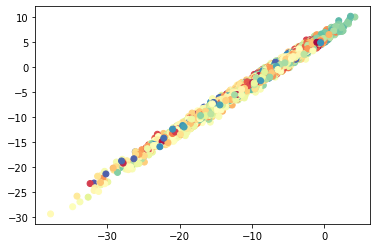

tensor([[106.5690,  50.7583],
        [ 50.7583,  39.1985]], grad_fn=<DivBackward0>)
Epoch=060, loss=10.6933, time=0.5186
loss before neg tensor(6.5515, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.7349, grad_fn=<NegBackward0>)
loss corr tensor(0.2509, grad_fn=<MulBackward0>)
loss final tensor(10.5373, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=061, loss=10.5373, time=0.3020
loss before neg tensor(6.1744, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.2330, grad_fn=<NegBackward0>)
loss corr tensor(1.6497, grad_fn=<MulBackward0>)
loss final tensor(11.0571, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=062, loss=11.0571, time=0.3872
loss before neg tensor(6.3741, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.3740, grad_fn=<NegBackward0>)
loss corr tensor(0.3652, grad_fn=<MulBackward0>)
loss final tensor(10.1132, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=063, loss=10.1132, time=0.3919
loss before ne

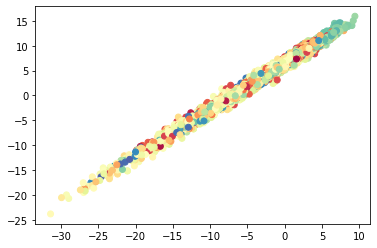

tensor([[50.5850, 28.0705],
        [28.0705, 50.5284]], grad_fn=<DivBackward0>)
Epoch=070, loss=9.7046, time=0.6144
loss before neg tensor(6.3323, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.2138, grad_fn=<NegBackward0>)
loss corr tensor(1.0055, grad_fn=<MulBackward0>)
loss final tensor(10.5516, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=071, loss=10.5516, time=0.3195
loss before neg tensor(6.1721, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.1442, grad_fn=<NegBackward0>)
loss corr tensor(0.6547, grad_fn=<MulBackward0>)
loss final tensor(9.9710, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=072, loss=9.9710, time=0.3167
loss before neg tensor(6.1288, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.1414, grad_fn=<NegBackward0>)
loss corr tensor(0.9578, grad_fn=<MulBackward0>)
loss final tensor(10.2280, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=073, loss=10.2280, time=0.3059
loss before neg tenso

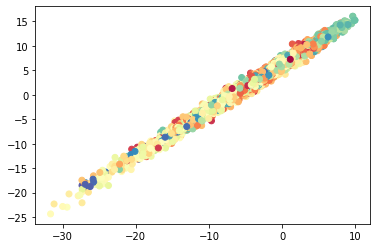

tensor([[53.0831, 32.1959],
        [32.1959, 52.6222]], grad_fn=<DivBackward0>)
Epoch=080, loss=9.6943, time=0.5151
loss before neg tensor(6.2303, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.1473, grad_fn=<NegBackward0>)
loss corr tensor(0.6264, grad_fn=<MulBackward0>)
loss final tensor(10.0040, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=081, loss=10.0040, time=0.3094
loss before neg tensor(6.1996, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.1699, grad_fn=<NegBackward0>)
loss corr tensor(0.4667, grad_fn=<MulBackward0>)
loss final tensor(9.8362, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=082, loss=9.8362, time=0.3244
loss before neg tensor(5.9108, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(2.7771, grad_fn=<NegBackward0>)
loss corr tensor(1.2705, grad_fn=<MulBackward0>)
loss final tensor(9.9583, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=083, loss=9.9583, time=0.2992
loss before neg tensor(

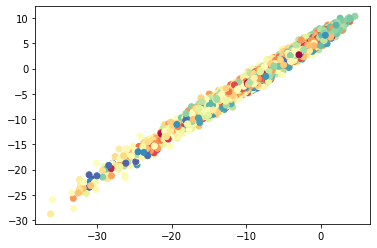

tensor([[100.4871,  47.0204],
        [ 47.0204,  39.0491]], grad_fn=<DivBackward0>)
Epoch=090, loss=10.0234, time=0.5901
loss before neg tensor(5.7494, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(2.9592, grad_fn=<NegBackward0>)
loss corr tensor(0.8450, grad_fn=<MulBackward0>)
loss final tensor(9.5536, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=091, loss=9.5536, time=0.3277
loss before neg tensor(5.7274, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(2.9232, grad_fn=<NegBackward0>)
loss corr tensor(0.5325, grad_fn=<MulBackward0>)
loss final tensor(9.1831, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=092, loss=9.1831, time=0.3439
loss before neg tensor(6.0597, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.1018, grad_fn=<NegBackward0>)
loss corr tensor(0.6679, grad_fn=<MulBackward0>)
loss final tensor(9.8295, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=093, loss=9.8295, time=0.3300
loss before neg tens

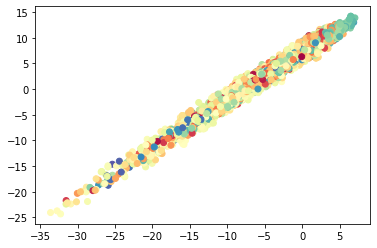

tensor([[67.0626, 28.8788],
        [28.8788, 47.7639]], grad_fn=<DivBackward0>)
Epoch=100, loss=9.2009, time=0.7324
loss before neg tensor(5.5398, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(2.7754, grad_fn=<NegBackward0>)
loss corr tensor(0.5445, grad_fn=<MulBackward0>)
loss final tensor(8.8597, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=101, loss=8.8597, time=0.3743
loss before neg tensor(5.5202, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(2.8693, grad_fn=<NegBackward0>)
loss corr tensor(1.0450, grad_fn=<MulBackward0>)
loss final tensor(9.4346, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=102, loss=9.4346, time=0.3299
loss before neg tensor(5.3180, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(2.6217, grad_fn=<NegBackward0>)
loss corr tensor(0.7829, grad_fn=<MulBackward0>)
loss final tensor(8.7226, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=103, loss=8.7226, time=0.3565
loss before neg tensor(5.

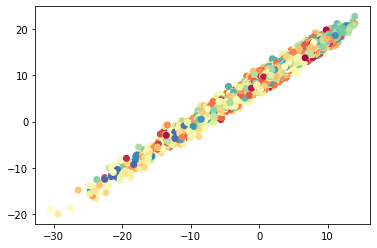

tensor([[ 50.5748,  59.5056],
        [ 59.5056, 140.5770]], grad_fn=<DivBackward0>)
Epoch=110, loss=10.2651, time=0.5144
loss before neg tensor(5.1390, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(2.6343, grad_fn=<NegBackward0>)
loss corr tensor(0.7718, grad_fn=<MulBackward0>)
loss final tensor(8.5450, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=111, loss=8.5450, time=0.3316
loss before neg tensor(5.2616, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(2.6185, grad_fn=<NegBackward0>)
loss corr tensor(0.9878, grad_fn=<MulBackward0>)
loss final tensor(8.8679, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=112, loss=8.8679, time=0.3103
loss before neg tensor(5.2652, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(2.7358, grad_fn=<NegBackward0>)
loss corr tensor(0.6276, grad_fn=<MulBackward0>)
loss final tensor(8.6287, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=113, loss=8.6287, time=0.3271
loss before neg tens

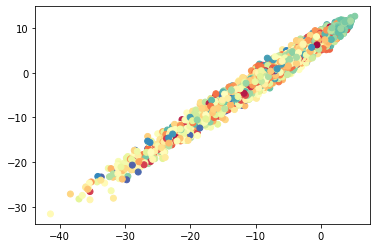

tensor([[112.1363,  50.7243],
        [ 50.7243,  50.0125]], grad_fn=<DivBackward0>)
Epoch=120, loss=9.0754, time=0.4757
loss before neg tensor(5.3407, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(2.6251, grad_fn=<NegBackward0>)
loss corr tensor(0.8670, grad_fn=<MulBackward0>)
loss final tensor(8.8328, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=121, loss=8.8328, time=0.2904
loss before neg tensor(5.3883, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(2.6098, grad_fn=<NegBackward0>)
loss corr tensor(0.8326, grad_fn=<MulBackward0>)
loss final tensor(8.8306, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=122, loss=8.8306, time=0.3007
loss before neg tensor(5.6943, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(2.9537, grad_fn=<NegBackward0>)
loss corr tensor(5.8596, grad_fn=<MulBackward0>)
loss final tensor(14.5076, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=123, loss=14.5076, time=0.3011
loss before neg ten

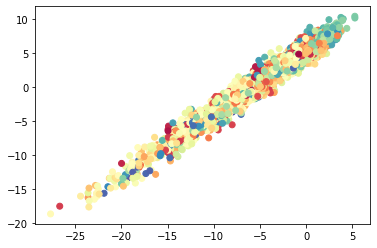

tensor([[42.2523, 16.3463],
        [16.3463, 24.5260]], grad_fn=<DivBackward0>)
Epoch=130, loss=10.3713, time=0.5945
loss before neg tensor(6.4129, dtype=torch.float64, grad_fn=<SubBackward0>)
loss after neg tensor(3.6406, grad_fn=<NegBackward0>)
loss corr tensor(0.8976, grad_fn=<MulBackward0>)
loss final tensor(10.9511, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch=131, loss=10.9511, time=0.3538
Early stopping at epoch 131!
Loading 111th epoch


<Figure size 432x288 with 0 Axes>

(array([[   9.,   27.,   84.,  189.,  413.,  816., 1035., 1313.,  114.,
            0.],
        [   0.,    0.,   14.,   32.,  115.,  266.,  532., 1034., 1318.,
          689.]]),
 array([-34.69086075, -29.67510605, -24.65935135, -19.64359665,
        -14.62784195,  -9.61208725,  -4.59633303,   0.41942149,
          5.4351759 ,  10.4509306 ,  15.4666853 ]),
 <a list of 2 BarContainer objects>)

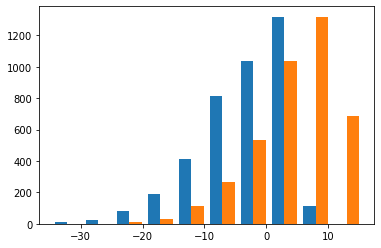

<Figure size 432x288 with 0 Axes>

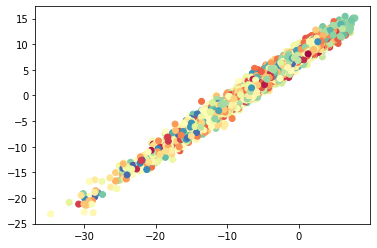

tensor([[60.8491, 29.4780],
        [29.4780, 61.6601]], grad_fn=<DivBackward0>)


In [358]:
new_data7 = copy.deepcopy(new_data)
model2, target_graph_index, vals, knn_dists=  train_gnumap(new_data7,
                                     target=None, hid_dim=256, dim=2,
                                     n_layers=3, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=50,
                                     norm='uniform', neighbours=5,
                                      beta=1, patience=20, epochs=1000,
                                      lr=1e-1,
                                    wd=1e-4,
                                    lambd_corr=1e-4,
                                       min_dist=0.01,
                       subsampling=100000)
out = model2(new_data7.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

In [ ]:
new_data6 = copy.deepcopy(new_data)
model2, target_graph_index, vals, knn_dists=  train_gnumap(new_data6,
                                     target=None, hid_dim=256, dim=2,
                                     n_layers=2, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=100,
                                     norm='uniform', neighbours=5,
                                      beta=1, patience=20, epochs=1000,
                                      lr=1e-1,
                                    wd=1e-4,
                                    lambd_corr=1e-4,
                                       min_dist=0.01,
                       subsampling=100000)
out = model2(new_data6.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

In [ ]:
new_data7 = copy.deepcopy(new_data)
model2, target_graph_index, vals, knn_dists=  train_gnumap(new_data7,
                                     target=None, hid_dim=256, dim=2,
                                     n_layers=2, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=20,
                                     norm='uniform', neighbours=5,
                                      beta=1, patience=20, epochs=1000,
                                      lr=1e-1,
                                    wd=1e-4,
                                    lambd_corr=1e-4,
                                       min_dist=0.01,
                       subsampling=100000)
out = model2(new_data7.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)

In [ ]:
#xx = torch.ones((X.shape[0], 10))
new_data9 = copy.deepcopy(new_data)
# new_data2.x =  new_data.x[:,:2] # leave out z-axis
model2, target_index =  train_gnumap(new_data9,
                                     target=None, hid_dim=512, dim=2,
                                     n_layers=1, must_propagate= [True, True, True, True, True],
                                     method = 'laplacian', alpha=0.5,
                                     gnn_type='symmetric', repulsion_strength=100.,
                                     norm='standardize', neighbours=2,
                                    beta=1, patience=20, epochs=1000,
                                       lr=1e-2,
                                       wd=1e-4,
                                        lambd_corr=1.,
                                       min_dist=0.001,
                       subsampling=100000)
out = model2(new_data9.x.float(), new_data.edge_index)
plt.figure()
plt.hist(out.detach().numpy())
plt.show()
u = out.detach().numpy()
plt.figure()
plt.scatter(u[:,0], u[:,1], c = t,
            cmap="Spectral")
plt.show()
print(torch.mm(out.T, out)/ new_data.num_nodes)